 # Skin Diasese detection test

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict to first GPU and set memory growth
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
tf.__version__

'2.10.0'

## Processing the training set

## Preprocessing the test set

In [4]:

# Common parameters
BATCH_SIZE   = 32
IMG_SIZE     = (128, 128)
DATA_DIR     = r"C:/Users/Uma Banik/OneDrive/Documents/7th sem/cse299/Skin-disease-dataset/main_dataset/train"
SEED         = 42           # keeps split reproducible
VAL_SPLIT    = 0.20         # 80 % train, 20 % validation


datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    validation_split=VAL_SPLIT      
)

training_set = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',              # ← **80 % of images**
    shuffle=True,
    seed=SEED
)

test_set = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',            # ← **20 % of images**
    shuffle=True,
    seed=SEED
)



Found 32904 images belonging to 5 classes.
Found 8224 images belonging to 5 classes.


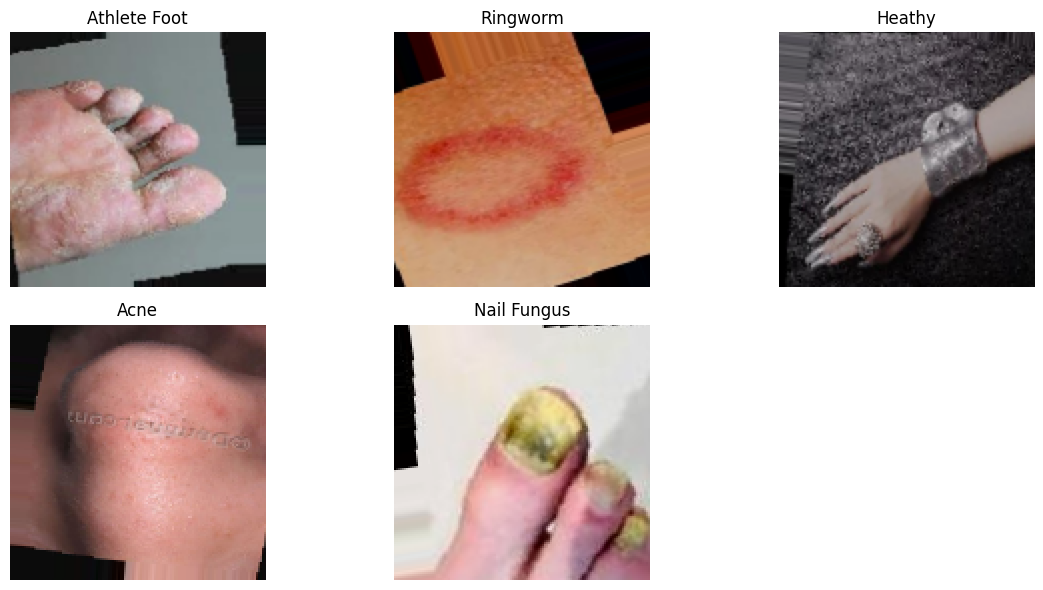

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load class indices (label → index mapping)
class_indices = training_set.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Create a map to store one image per class
seen_classes = set()
images = []
labels = []

# Iterate over batches to collect one image per class
for i in range(len(training_set)):
    x_batch, y_batch = training_set[i]
    for img, label in zip(x_batch, y_batch):
        class_index = np.argmax(label)
        if class_index not in seen_classes:
            seen_classes.add(class_index)
            images.append(img)
            labels.append(index_to_class[class_index])
        if len(seen_classes) == len(index_to_class):
            break
    if len(seen_classes) == len(index_to_class):
        break

# Plot the collected images
plt.figure(figsize=(12, 6))
for i in range(len(images)):
    plt.subplot(2, (len(images) + 1) // 2, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis("off")
plt.tight_layout()
plt.show()


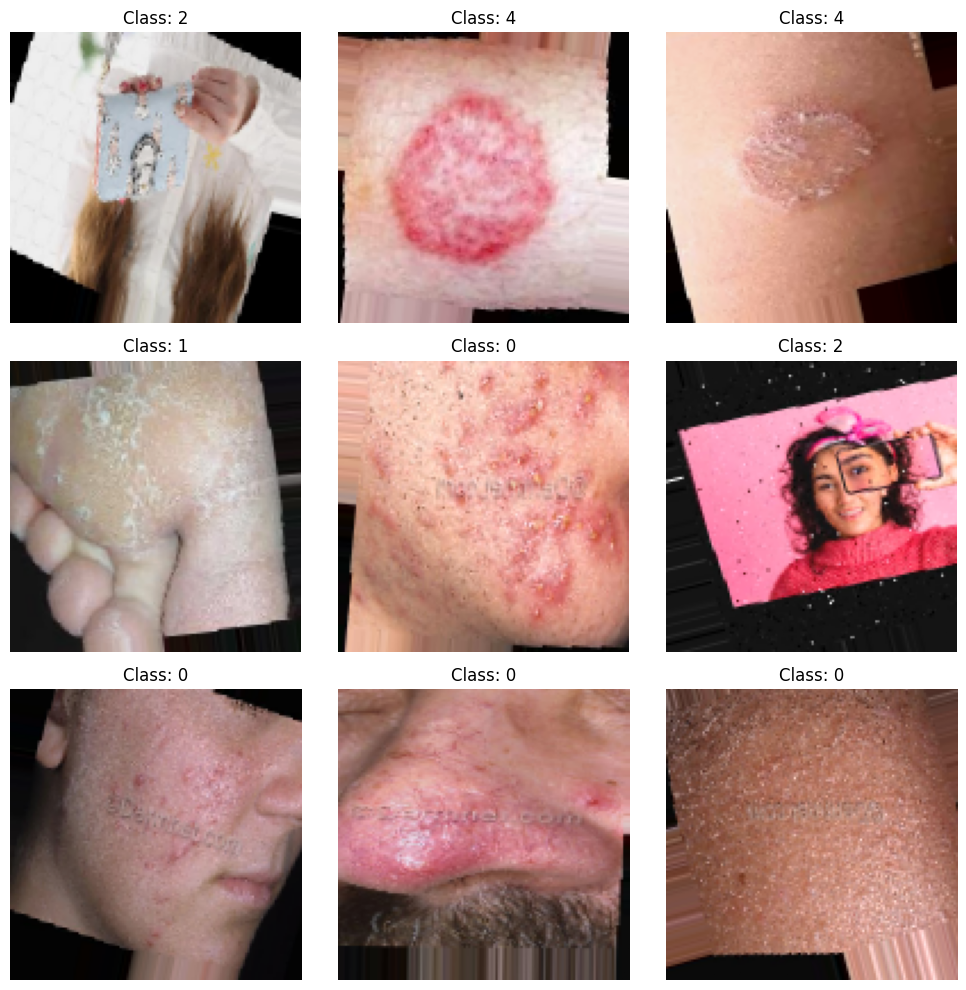

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch from the training set
images, labels = next(training_set)

# Show 9 augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {np.argmax(labels[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()


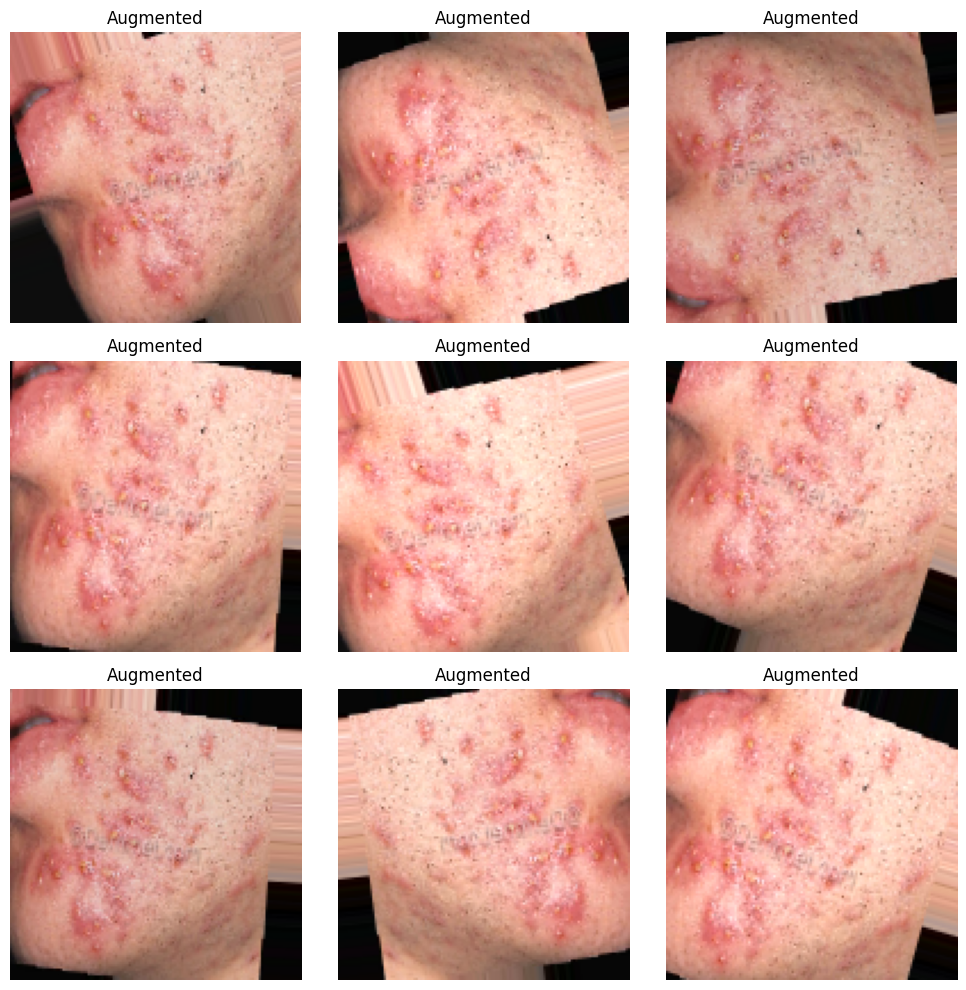

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Load a single image path
img_path = training_set.filepaths[0]
img = image.load_img(img_path, target_size=IMG_SIZE)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Show multiple augmented versions
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented = datagen.flow(x, batch_size=1)
    aug_img = next(augmented)[0]  # single image in batch
    plt.subplot(3, 3, i + 1)
    plt.imshow(aug_img)
    plt.title("Augmented")
    plt.axis("off")
plt.tight_layout()
plt.show()

## Building the CNN

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint


# Load Pretrained MobileNetV2 (Exclude top layers)
base_model = MobileNetV2(input_shape=(128, 128, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-40]: 
    layer.trainable = False



# Add Custom Classification Head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])


# Train Model
callbacks = [
    EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

# Stage 1
base_model.trainable = False
model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model.fit(training_set, validation_data=test_set, epochs=10, callbacks=callbacks)

# Stage 2
base_model.trainable = True
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model.fit(training_set, validation_data=test_set, epochs=20, callbacks=callbacks)



Epoch 1/10
1029/1029 [==============================] - 267s 249ms/step - loss: 0.2117 - accuracy: 0.9292 - val_loss: 0.0806 - val_accuracy: 0.9729 - lr: 0.0010
Epoch 2/10
1029/1029 [==============================] - 230s 224ms/step - loss: 0.1085 - accuracy: 0.9646 - val_loss: 0.0701 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 3/10
1029/1029 [==============================] - 273s 266ms/step - loss: 0.0957 - accuracy: 0.9690 - val_loss: 0.0509 - val_accuracy: 0.9848 - lr: 0.0010
Epoch 4/10
1029/1029 [==============================] - 192s 186ms/step - loss: 0.0788 - accuracy: 0.9752 - val_loss: 0.0456 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 5/10
1029/1029 [==============================] - 167s 162ms/step - loss: 0.0709 - accuracy: 0.9772 - val_loss: 0.0734 - val_accuracy: 0.9802 - lr: 0.0010
Epoch 6/10
1029/1029 [==============================] - 185s 180ms/step - loss: 0.0675 - accuracy: 0.9782 - val_loss: 0.0661 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 7/10
1029/1029 [============

In [9]:
# Training progress
# Combine history from both stages
import pandas as pd

combined_history = {}
for key in history1.history:
    combined_history[key] = history1.history[key] + history2.history[key]



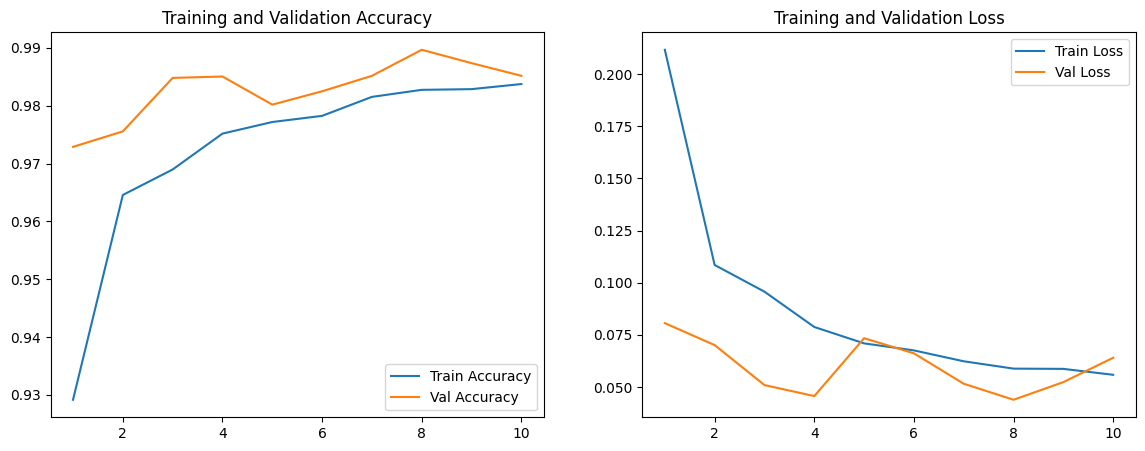

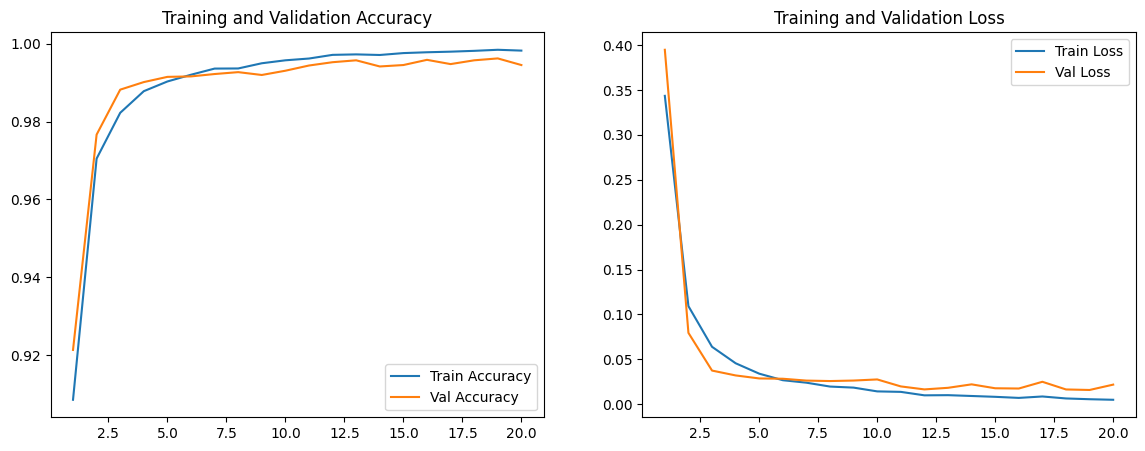

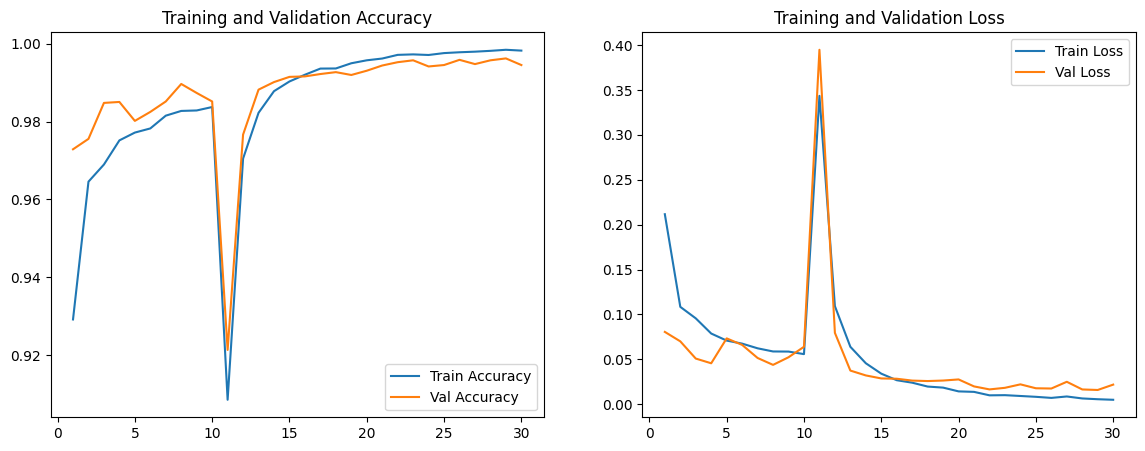

In [10]:
# Training progress
import matplotlib.pyplot as plt

def plot_history(history_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Use for single stage:
plot_history(history1.history)
plot_history(history2.history)

# Or for combined:
plot_history(combined_history)


1/1 [==============================] - 0s 26ms/step


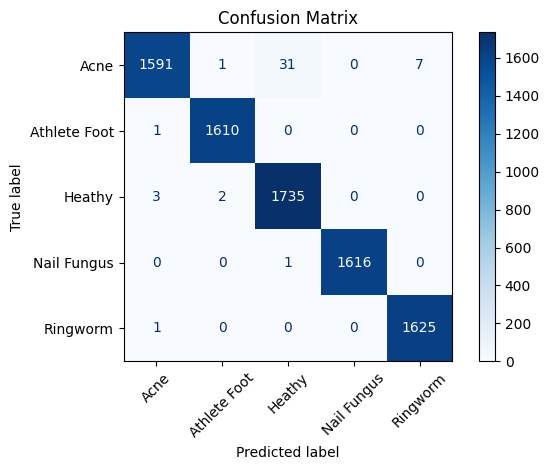

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Get true labels and predictions
Y_true = []
Y_pred = []

# Go through test batches and collect predictions
for i in range(len(test_set)):
    x_batch, y_batch = test_set[i]
    y_pred_batch = model.predict(x_batch)
    
    Y_true.extend(np.argmax(y_batch, axis=1))
    Y_pred.extend(np.argmax(y_pred_batch, axis=1))

    if (i + 1) * test_set.batch_size >= test_set.samples:
        break  # Stop if we've processed all test data

# 2. Compute confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
labels = list(test_set.class_indices.keys())  # Class names

# 3. Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [12]:
model.save('299-model-test-v7')

INFO:tensorflow:Assets written to: 299-model-test-v7\assets


INFO:tensorflow:Assets written to: 299-model-test-v7\assets


In [ ]:
model.save('299-model-test-v7.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
import gc

K.clear_session()
gc.collect()

In [5]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('299-model-test-v7.h5')

In [6]:

# =============================================================================
# GAN-BASED ANOMALY DETECTION IMPLEMENTATION
# =============================================================================

import tensorflow as tf
import gc
import os

class MemoryEfficientGAN(tf.keras.Model):
    def __init__(self, latent_dim=100):
        super(MemoryEfficientGAN, self).__init__()
        self.latent_dim = latent_dim
        
        # Build generator
        self.generator = self.build_generator()
        
        # Build discriminator
        self.discriminator = self.build_discriminator()
        
        # Build feature extractor (encoder part)
        self.feature_extractor = self.build_feature_extractor()
        
    def build_generator(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(8*8*256, use_bias=False, input_shape=(self.latent_dim,)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape((8, 8, 256)),
            
            tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, 
                                          activation='tanh')
        ], name="generator")
        
        return model
    
    def build_discriminator(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same', input_shape=[128, 128, 3]),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1)
        ], name="discriminator")
        
        return model
    
    def build_feature_extractor(self):
        """Build feature extractor for anomaly detection"""
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same', input_shape=[128, 128, 3]),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(512),
            tf.keras.layers.LeakyReLU(),
        ], name="feature_extractor")
        
        return model


Starting GAN training with memory-efficient approach...
Initializing GAN for anomaly detection...
Training GAN for 40 epochs...
Using approximately 8000 images per epoch
Epoch 5/40: Gen Loss: 0.9780, Disc Loss: 1.1710
Epoch 10/40: Gen Loss: 1.1970, Disc Loss: 1.0025


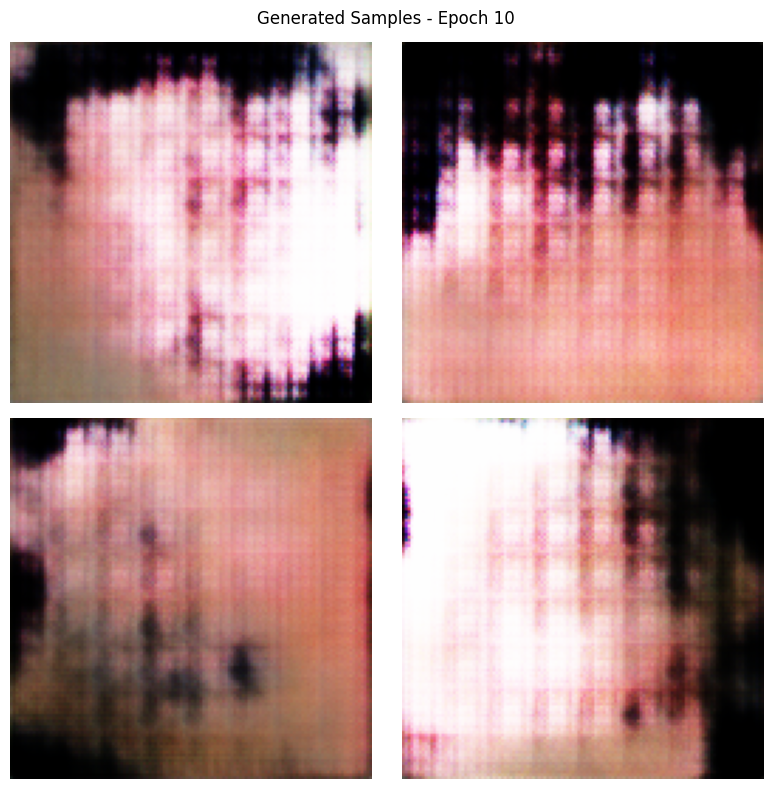

Epoch 15/40: Gen Loss: 1.5698, Disc Loss: 0.8187
Epoch 20/40: Gen Loss: 1.5164, Disc Loss: 0.8308


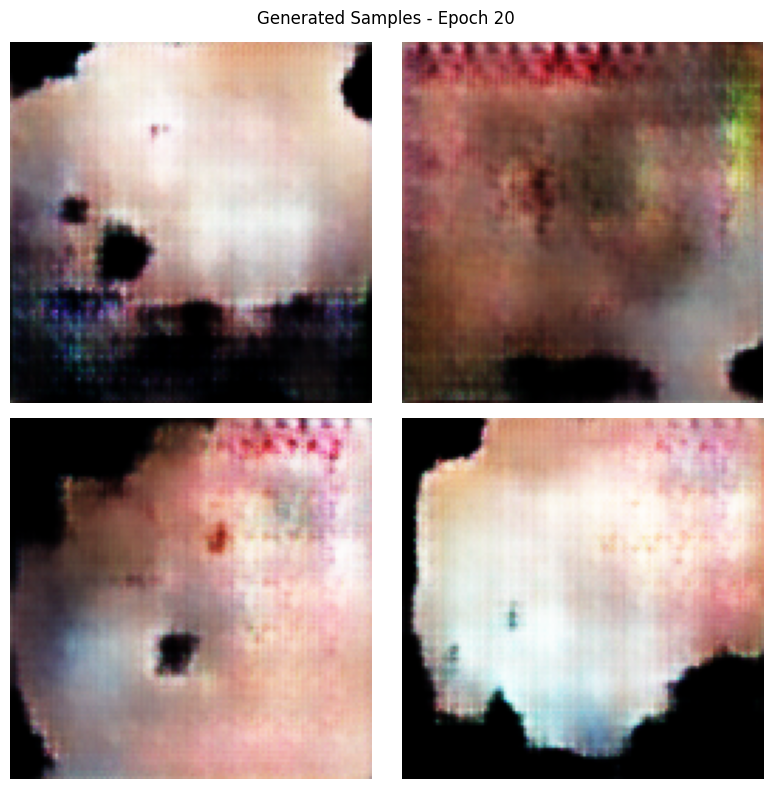

Epoch 25/40: Gen Loss: 1.6170, Disc Loss: 0.8043
Epoch 30/40: Gen Loss: 1.7622, Disc Loss: 0.7428


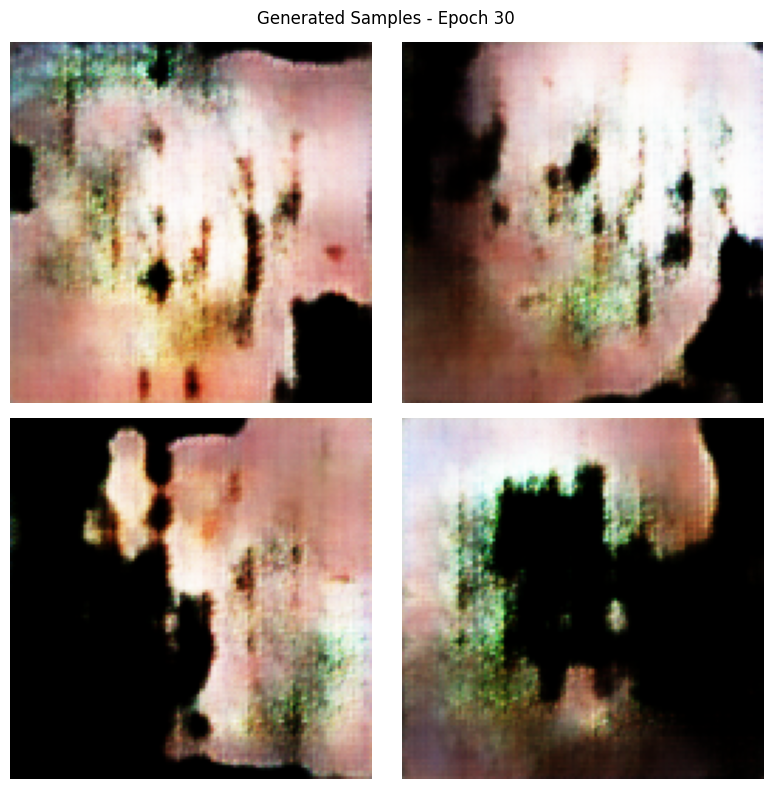

Epoch 35/40: Gen Loss: 1.7189, Disc Loss: 0.7761
Epoch 40/40: Gen Loss: 1.5502, Disc Loss: 0.8597


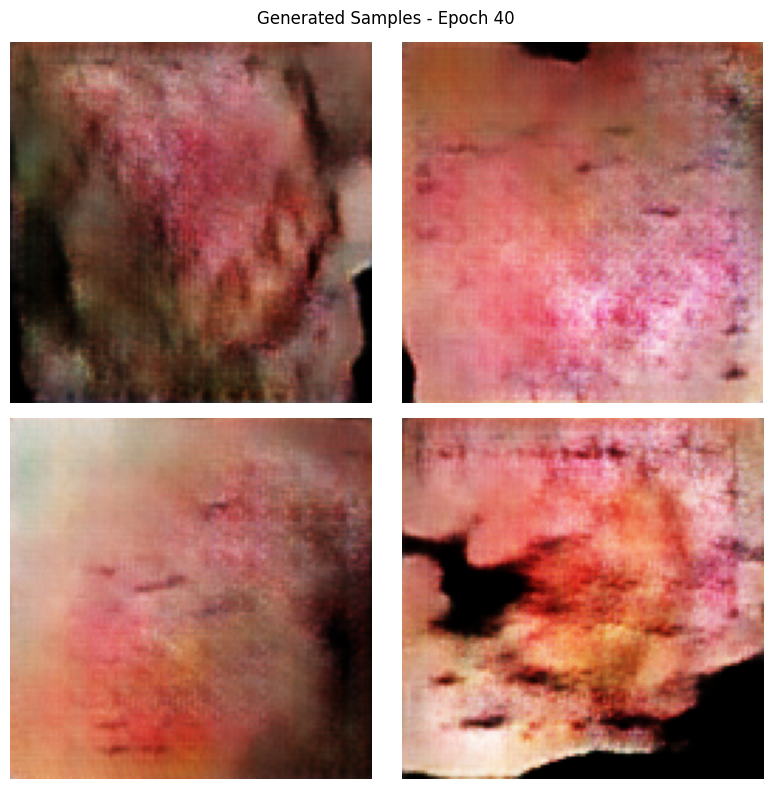


✅ GAN training completed!


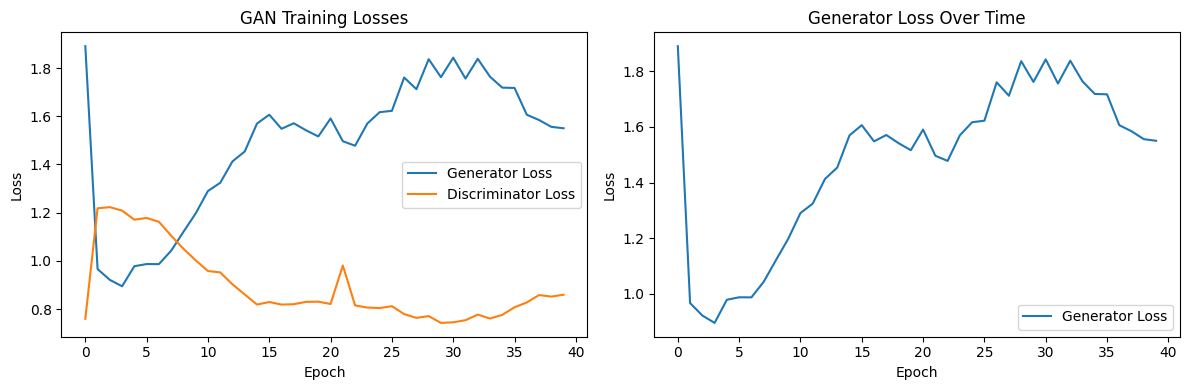

In [ ]:
import numpy as np
import tensorflow as tf
import gc
import matplotlib.pyplot as plt
import os

def create_memory_efficient_dataset(data_generator, max_batches_per_epoch=200):
    
    def data_gen():
        batch_count = 0
        while True:
            try:
                # Reset generator periodically to get different samples
                if batch_count % max_batches_per_epoch == 0:
                    data_generator.reset()
                
                batch_x, batch_y = next(data_generator)
                # Normalize to [-1, 1] for GAN training
                batch_x = (batch_x * 2.0) - 1.0
                
                yield batch_x
                batch_count += 1
                
                # Memory cleanup every 50 batches
                if batch_count % 50 == 0:
                    gc.collect()
                    
            except StopIteration:
                data_generator.reset()
                continue
    
    # Create dataset
    dataset = tf.data.Dataset.from_generator(
        data_gen,
        output_signature=tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32)
    )
    
    return dataset.prefetch(tf.data.AUTOTUNE)

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def feature_matching_loss(real_features, fake_features):
    return tf.reduce_mean(tf.abs(real_features - fake_features))

# Training step
@tf.function
def train_step(images, gan_model, gen_optimizer, disc_optimizer, latent_dim):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gan_model.generator(noise, training=True)

        real_output = gan_model.discriminator(images, training=True)
        fake_output = gan_model.discriminator(generated_images, training=True)
        
        # Feature matching for better quality
        real_features = gan_model.feature_extractor(images, training=True)
        fake_features = gan_model.feature_extractor(generated_images, training=True)

        gen_loss = generator_loss(fake_output) + 0.1 * feature_matching_loss(real_features, fake_features)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gan_model.generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, gan_model.discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, gan_model.generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, gan_model.discriminator.trainable_variables))
    
    return gen_loss, disc_loss

def train_gan(training_set, epochs=50, latent_dim=100, max_batches_per_epoch=200):
    """Train GAN with memory-efficient approach using more training data"""
    
    print("Initializing GAN for anomaly detection...")
    print("="*60)
    
    # Create GAN model
    gan_model = MemoryEfficientGAN(latent_dim=latent_dim)
    
    # Optimizers
    generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    # Create memory-efficient dataset
    train_dataset = create_memory_efficient_dataset(training_set, max_batches_per_epoch)
    
    # Training metrics
    gen_losses = []
    disc_losses = []
    
    print(f"Training GAN for {epochs} epochs...")
    print(f"Using approximately {max_batches_per_epoch * BATCH_SIZE} images per epoch")
    print("="*60)
    
    for epoch in range(epochs):
        epoch_gen_loss = []
        epoch_disc_loss = []
        
        # Train for specified number of batches per epoch
        batch_count = 0
        for image_batch in train_dataset:
            if batch_count >= max_batches_per_epoch:
                break
                
            gen_loss, disc_loss = train_step(
                image_batch, gan_model, generator_optimizer, 
                discriminator_optimizer, latent_dim
            )
            
            epoch_gen_loss.append(gen_loss)
            epoch_disc_loss.append(disc_loss)
            batch_count += 1
        
        # Calculate average losses
        avg_gen_loss = np.mean(epoch_gen_loss)
        avg_disc_loss = np.mean(epoch_disc_loss)
        
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch + 1}/{epochs}: Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}')
            
            # Generate sample images for visual inspection
            if (epoch + 1) % 10 == 0:
                sample_noise = tf.random.normal([4, latent_dim])
                generated_samples = gan_model.generator(sample_noise, training=False)
                
                plt.figure(figsize=(8, 8))
                for i in range(4):
                    plt.subplot(2, 2, i + 1)
                    # Convert from [-1, 1] to [0, 1] for display
                    img = (generated_samples[i] + 1.0) / 2.0
                    plt.imshow(img)
                    plt.axis('off')
                plt.suptitle(f'Generated Samples - Epoch {epoch + 1}')
                plt.tight_layout()
                plt.show()
        
        # Memory cleanup
        if (epoch + 1) % 10 == 0:
            gc.collect()
    
    print("\n✅ GAN training completed!")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.title('GAN Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(gen_losses, label='Generator Loss')
    plt.title('Generator Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return gan_model, gen_losses, disc_losses

# Train the GAN
print("Starting GAN training with memory-efficient approach...")
gan_model, gen_losses, disc_losses = train_gan(
    training_set, 
    epochs=40,  # Reduced epochs due to more data per epoch
    latent_dim=100,
    max_batches_per_epoch=250  # Using ~8000 images per epoch (250 * 32)
)



Preparing training data for GAN anomaly detection...
Collected 1000/6000 samples...
Collected 2000/6000 samples...
Collected 3000/6000 samples...
Collected 4000/6000 samples...
Collected 5000/6000 samples...
Collected 6000/6000 samples...
Calculating GAN-based anomaly scores on training data...

GAN Anomaly Score Thresholds:
35th percentile: 0.081837
40th percentile: 0.107895
45th percentile: 0.138362
50th percentile: 0.169228
55th percentile: 0.204217
60th percentile: 0.239374
65th percentile: 0.279422
70th percentile: 0.315693
75th percentile: 0.356914
80th percentile: 0.397402
85th percentile: 0.436385

Using 0.081837 as GAN anomaly detection threshold


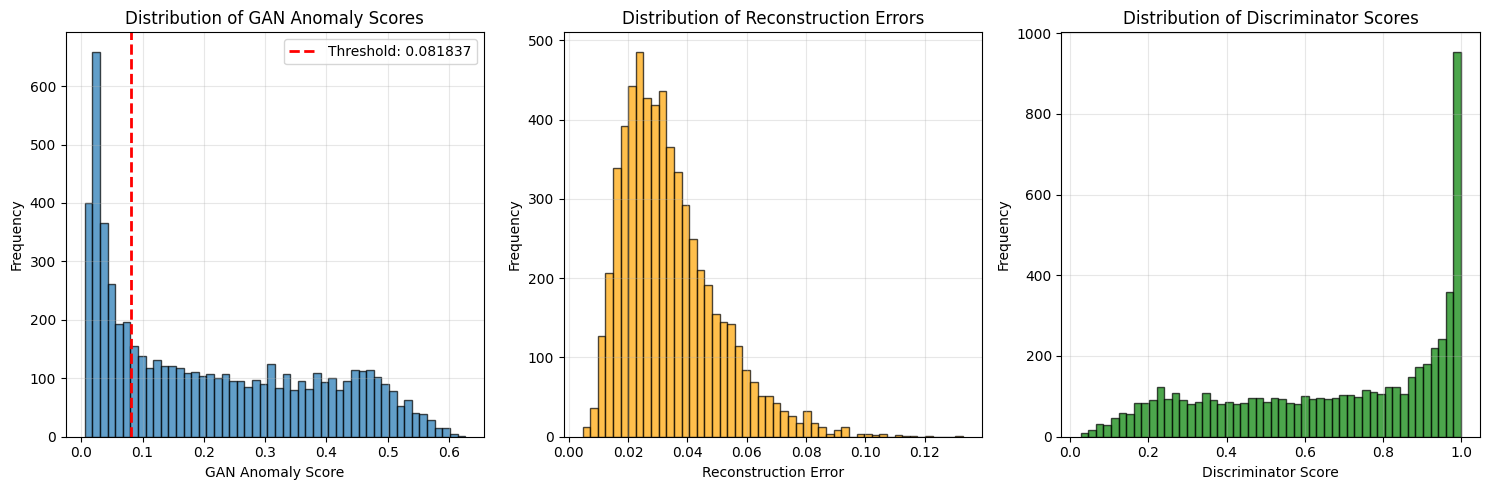


📊 GAN Anomaly Score Statistics:
Mean: 0.210132
Std: 0.170982
Min: 0.005680
Max: 0.626196

✅ GAN-based anomaly detection setup completed!


In [15]:
def calculate_gan_anomaly_scores(gan_model, images, batch_size=8):
    """Calculate anomaly scores using GAN-based approach"""
    
    anomaly_scores = []
    reconstruction_errors = []
    discriminator_scores = []
    
    num_batches = (len(images) + batch_size - 1) // batch_size
    
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        
        # Normalize to [-1, 1] for GAN
        batch_normalized = (batch * 2.0) - 1.0
        
        # Method 1: Discriminator score (how "real" the image looks)
        disc_scores = gan_model.discriminator(batch_normalized, training=False)
        disc_scores = tf.nn.sigmoid(disc_scores).numpy().flatten()
        
        # Method 2: Feature-based reconstruction error
        real_features = gan_model.feature_extractor(batch_normalized, training=False)
        
        # Try to find the best latent representation
        best_reconstruction_errors = []
        
        for img_idx in range(batch.shape[0]):
            single_img = batch_normalized[img_idx:img_idx+1]
            single_real_features = real_features[img_idx:img_idx+1]
            
            # Multiple attempts to find best reconstruction
            best_error = float('inf')
            for attempt in range(5):  # Multiple random attempts
                noise = tf.random.normal([1, gan_model.latent_dim])
                generated_img = gan_model.generator(noise, training=False)
                generated_features = gan_model.feature_extractor(generated_img, training=False)
                
                # Feature-based reconstruction error
                feature_error = tf.reduce_mean(tf.square(single_real_features - generated_features)).numpy()
                
                # Image-based reconstruction error
                img_error = tf.reduce_mean(tf.square(single_img - generated_img)).numpy()
                
                # Combined error
                combined_error = feature_error + 0.1 * img_error
                
                if combined_error < best_error:
                    best_error = combined_error
            
            best_reconstruction_errors.append(best_error)
        
        # Combine discriminator score and reconstruction error
        for j in range(len(disc_scores)):
            # Lower discriminator score = more likely to be anomaly
            # Higher reconstruction error = more likely to be anomaly
            disc_anomaly_score = 1.0 - disc_scores[j]  # Invert discriminator score
            recon_anomaly_score = best_reconstruction_errors[j]
            
            # Weighted combination
            combined_score = 0.6 * disc_anomaly_score + 0.4 * recon_anomaly_score
            
            anomaly_scores.append(combined_score)
            reconstruction_errors.append(best_reconstruction_errors[j])
            discriminator_scores.append(disc_scores[j])
    
    return (np.array(anomaly_scores), 
            np.array(reconstruction_errors), 
            np.array(discriminator_scores))

def prepare_gan_training_data(data_generator, num_samples=8000):
    """Prepare training data for threshold calculation"""
    
    images = []
    samples_collected = 0
    
    print(f"Collecting {num_samples} training samples for threshold calculation...")
    
    while samples_collected < num_samples:
        try:
            batch_x, batch_y = next(data_generator)
            for img in batch_x:
                if samples_collected >= num_samples:
                    break
                images.append(img)
                samples_collected += 1
                
                if samples_collected % 1000 == 0:
                    print(f"Collected {samples_collected}/{num_samples} samples...")
                    
        except StopIteration:
            data_generator.reset()
            continue
    
    return np.array(images)

# Prepare training data for threshold calculation
print("Preparing training data for GAN anomaly detection...")
train_images_for_threshold = prepare_gan_training_data(training_set, num_samples=6000)

print("Calculating GAN-based anomaly scores on training data...")
train_anomaly_scores, train_reconstruction_errors, train_disc_scores = calculate_gan_anomaly_scores(
    gan_model, train_images_for_threshold, batch_size=8
)

# Calculate thresholds
threshold_percentiles = [35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
print("\nGAN Anomaly Score Thresholds:")
for percentile in threshold_percentiles:
    threshold = np.percentile(train_anomaly_scores, percentile)
    print(f"{percentile}th percentile: {threshold:.6f}")

# Use a more conservative threshold for better balance
gan_threshold = np.percentile(train_anomaly_scores, 35)  # Adjust as needed
print(f"\nUsing {gan_threshold:.6f} as GAN anomaly detection threshold")

# Plot anomaly score distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(train_anomaly_scores, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(gan_threshold, color='red', linestyle='--', linewidth=2,
            label=f'Threshold: {gan_threshold:.6f}')
plt.xlabel('GAN Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of GAN Anomaly Scores')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(train_reconstruction_errors, bins=50, alpha=0.7, edgecolor='black', color='orange')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(train_disc_scores, bins=50, alpha=0.7, edgecolor='black', color='green')
plt.xlabel('Discriminator Score')
plt.ylabel('Frequency')
plt.title('Distribution of Discriminator Scores')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 GAN Anomaly Score Statistics:")
print(f"Mean: {np.mean(train_anomaly_scores):.6f}")
print(f"Std: {np.std(train_anomaly_scores):.6f}")
print(f"Min: {np.min(train_anomaly_scores):.6f}")
print(f"Max: {np.max(train_anomaly_scores):.6f}")

print("\n✅ GAN-based anomaly detection setup completed!")



In [20]:
# =============================================================================
# HYBRID PREDICTION WITH GAN
# =============================================================================

def hybrid_prediction_gan(image_path, cnn_model, gan_model, gan_threshold, 
                         cnn_confidence_threshold=0.9, target_size=(128, 128)):
    """Hybrid prediction using CNN + GAN for anomaly detection"""
    
    # Load and preprocess image
    test_image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    test_image_array = tf.keras.preprocessing.image.img_to_array(test_image)
    test_image_array = np.expand_dims(test_image_array, axis=0)
    test_image_normalized = test_image_array / 255.0
    
    # CNN Prediction
    cnn_prediction = cnn_model.predict(test_image_normalized, verbose=0)
    predicted_class_index = np.argmax(cnn_prediction)
    cnn_confidence = np.max(cnn_prediction)
    
    # Get class names
    class_names = list(training_set.class_indices.keys())
    predicted_class = class_names[predicted_class_index]
    
    # Decision logic
    if cnn_confidence >= cnn_confidence_threshold:
        is_anomaly = False
        anomaly_score = 0.0
        reconstruction_error = 0.0
        discriminator_score = 1.0
        decision_path = "CNN_HIGH_CONFIDENCE"
        final_prediction = predicted_class
    else:
        # Low confidence CNN prediction - use GAN for anomaly detection
        gan_anomaly_scores, gan_recon_errors, gan_disc_scores = calculate_gan_anomaly_scores(
            gan_model, test_image_normalized, batch_size=1
        )
        
        anomaly_score = gan_anomaly_scores[0]
        reconstruction_error = gan_recon_errors[0]
        discriminator_score = gan_disc_scores[0]
        
        # Enhanced anomaly detection logic
        is_anomaly = (anomaly_score > gan_threshold) or (cnn_confidence < 0.70)
        decision_path = "GAN_ANOMALY_CHECK"
        
        if is_anomaly:
            final_prediction = "ANOMALY"
        else:
            final_prediction = predicted_class
    
    return {
        'predicted_class': predicted_class,
        'final_prediction': final_prediction,
        'cnn_confidence': cnn_confidence,
        'gan_anomaly_score': anomaly_score,
        'reconstruction_error': reconstruction_error,
        'discriminator_score': discriminator_score,
        'is_anomaly': is_anomaly,
        'gan_threshold': gan_threshold,
        'cnn_confidence_threshold': cnn_confidence_threshold,
        'decision_path': decision_path
    }

def test_hybrid_prediction_gan(image_path, cnn_confidence_threshold=0.9):
    """Test hybrid prediction with GAN"""
    try:
        result = hybrid_prediction_gan(image_path, model, gan_model, gan_threshold, 
                                     cnn_confidence_threshold=cnn_confidence_threshold)
        
        print(f"Image: {image_path}")
        print(f"Decision Path: {result['decision_path']}")
        print(f"CNN Predicted Class: {result['predicted_class']}")
        print(f"CNN Confidence: {result['cnn_confidence']:.4f}")
        print(f"Final Prediction: {result['final_prediction']}")
        
        if result['decision_path'] == "GAN_ANOMALY_CHECK":
            print(f"GAN Anomaly Score: {result['gan_anomaly_score']:.6f}")
            print(f"Reconstruction Error: {result['reconstruction_error']:.6f}")
            print(f"Discriminator Score: {result['discriminator_score']:.6f}")
            print(f"GAN Threshold: {result['gan_threshold']:.6f}")
        
        if result['is_anomaly']:
            print("⚠️ ANOMALY DETECTED - This image shows unusual patterns!")
        else:
            print("✅ Normal image")
        
        print("-" * 50)
        return result
        
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

def get_image_paths_from_folders(folders, extensions=['.jpg', '.jpeg', '.png', '.webp']):
    """Get all image paths from given folders"""
    image_paths = []
    for folder in folders:
        for root, dirs, files in os.walk(folder):
            for file in files:
                if any(file.lower().endswith(ext) for ext in extensions):
                    image_paths.append(os.path.join(root, file))
    return image_paths



In [21]:
# =============================================================================
# COMPREHENSIVE EVALUATION WITH ENHANCED METRICS
# =============================================================================

import csv
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, precision_recall_curve,
    f1_score, precision_score, recall_score, accuracy_score
)
import matplotlib.pyplot as plt

def evaluate_hybrid_gan_detector(normal_folder, anomaly_folder, gan_threshold, 
                                cnn_confidence_threshold=0.9, 
                                csv_filename='gan_anomaly_results1.csv'):
    """
    Comprehensive evaluation of hybrid GAN-based anomaly detector with detailed metrics
    """
    
    normal_image_paths = get_image_paths_from_folders([normal_folder])
    anomaly_image_paths = get_image_paths_from_folders([anomaly_folder])

    results = []
    y_true = []  # 0 = normal, 1 = anomaly
    y_pred = []  # 0 = normal, 1 = anomaly
    y_scores = []  # Anomaly scores for ROC curve
    
    # Detailed counters
    true_positive = 0  # Anomaly correctly detected as anomaly
    false_positive = 0  # Normal incorrectly detected as anomaly
    true_negative = 0  # Normal correctly detected as normal
    false_negative = 0  # Anomaly incorrectly detected as normal
    
    # Track decision paths
    cnn_high_conf_decisions = 0
    gan_anomaly_decisions = 0

    print(f"\n🔍 EVALUATING HYBRID GAN ANOMALY DETECTOR")
    print("="*70)
    print(f"CNN confidence threshold: {cnn_confidence_threshold}")
    print(f"GAN anomaly threshold: {gan_threshold:.6f}")
    print("="*70)

    print(f"\n📊 Processing {len(normal_image_paths)} normal images...")
    for i, img_path in enumerate(normal_image_paths):
        if i % 50 == 0:
            print(f"  Progress: {i}/{len(normal_image_paths)}")
            
        result = hybrid_prediction_gan(img_path, model, gan_model, gan_threshold, cnn_confidence_threshold)
        
        if result:
            is_anomaly = result.get('is_anomaly', False)
            decision_path = result.get('decision_path', 'UNKNOWN')
            anomaly_score = result.get('gan_anomaly_score', 0)
            
            # Track decision paths
            if decision_path == "CNN_HIGH_CONFIDENCE":
                cnn_high_conf_decisions += 1
            elif decision_path == "GAN_ANOMALY_CHECK":
                gan_anomaly_decisions += 1
            
            # Ground truth and predictions
            y_true.append(0)  # Normal
            y_pred.append(1 if is_anomaly else 0)
            y_scores.append(anomaly_score)
            
            if is_anomaly:
                false_positive += 1
            else:
                true_negative += 1
                
            results.append({
                'image': os.path.basename(img_path),
                'true_label': 'normal',
                'predicted_class': result.get('predicted_class', 'N/A'),
                'final_prediction': result.get('final_prediction', 'N/A'),
                'cnn_confidence': result.get('cnn_confidence', 0),
                'gan_anomaly_score': anomaly_score,
                'reconstruction_error': result.get('reconstruction_error', 0),
                'discriminator_score': result.get('discriminator_score', 0),
                'is_anomaly': is_anomaly,
                'decision_path': decision_path
            })

    print(f"\n📊 Processing {len(anomaly_image_paths)} anomalous images...")
    for i, img_path in enumerate(anomaly_image_paths):
        if i % 50 == 0:
            print(f"  Progress: {i}/{len(anomaly_image_paths)}")
            
        result = hybrid_prediction_gan(img_path, model, gan_model, gan_threshold, cnn_confidence_threshold)
        
        if result:
            is_anomaly = result.get('is_anomaly', False)
            decision_path = result.get('decision_path', 'UNKNOWN')
            anomaly_score = result.get('gan_anomaly_score', 0)
            
            # Track decision paths
            if decision_path == "CNN_HIGH_CONFIDENCE":
                cnn_high_conf_decisions += 1
            elif decision_path == "GAN_ANOMALY_CHECK":
                gan_anomaly_decisions += 1
            
            # Ground truth and predictions
            y_true.append(1)  # Anomaly
            y_pred.append(1 if is_anomaly else 0)
            y_scores.append(anomaly_score)
            
            if is_anomaly:
                true_positive += 1
            else:
                false_negative += 1
                
            results.append({
                'image': os.path.basename(img_path),
                'true_label': 'anomaly',
                'predicted_class': result.get('predicted_class', 'N/A'),
                'final_prediction': result.get('final_prediction', 'N/A'),
                'cnn_confidence': result.get('cnn_confidence', 0),
                'gan_anomaly_score': anomaly_score,
                'reconstruction_error': result.get('reconstruction_error', 0),
                'discriminator_score': result.get('discriminator_score', 0),
                'is_anomaly': is_anomaly,
                'decision_path': decision_path
            })

    # Convert to numpy arrays for metrics calculation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)
    
    # Calculate comprehensive metrics
    total_normals = true_negative + false_positive
    total_anomalies = true_positive + false_negative
    total_images = total_normals + total_anomalies
    
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)  # Also known as sensitivity/TPR
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Detailed rates
    false_positive_rate = false_positive / total_normals if total_normals > 0 else 0
    false_negative_rate = false_negative / total_anomalies if total_anomalies > 0 else 0
    true_positive_rate = recall  # Same as recall
    true_negative_rate = true_negative / total_normals if total_normals > 0 else 0  # Specificity
    
    # ROC AUC (only if we have both classes)
    try:
        roc_auc = roc_auc_score(y_true, y_scores) if len(np.unique(y_true)) > 1 else 0
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)
    except:
        roc_auc = 0
        fpr, tpr = [], []
        precision_curve, recall_curve = [], []

    # Print comprehensive results
    print("\n" + "="*80)
    print("🎯 HYBRID GAN ANOMALY DETECTION EVALUATION RESULTS")
    print("="*80)
    print(f"📋 Configuration:")
    print(f"   CNN Confidence Threshold: {cnn_confidence_threshold}")
    print(f"   GAN Anomaly Threshold: {gan_threshold:.6f}")
    print(f"   Total Images Processed: {total_images}")
    print(f"   Normal Images: {total_normals}")
    print(f"   Anomalous Images: {total_anomalies}")
    
    print(f"\n🛣️  Decision Path Analysis:")
    print(f"   CNN High Confidence Decisions: {cnn_high_conf_decisions} ({cnn_high_conf_decisions/total_images*100:.1f}%)")
    print(f"   GAN Anomaly Check Decisions: {gan_anomaly_decisions} ({gan_anomaly_decisions/total_images*100:.1f}%)")
    
    print(f"\n📊 Confusion Matrix:")
    print(f"   True Positives (Anomalies detected correctly): {true_positive}")
    print(f"   True Negatives (Normals detected correctly): {true_negative}")
    print(f"   False Positives (Normals detected as anomalies): {false_positive}")
    print(f"   False Negatives (Anomalies detected as normals): {false_negative}")
    
    print(f"\n🎯 Performance Metrics:")
    print(f"   Overall Accuracy: {accuracy * 100:.2f}%")
    print(f"   Precision (Anomaly detection precision): {precision * 100:.2f}%")
    print(f"   Recall/Sensitivity (Anomalies correctly detected): {recall * 100:.2f}%")
    print(f"   F1-Score: {f1 * 100:.2f}%")
    print(f"   Specificity (Normals correctly detected): {true_negative_rate * 100:.2f}%")
    print(f"   False Positive Rate: {false_positive_rate * 100:.2f}%")
    print(f"   False Negative Rate: {false_negative_rate * 100:.2f}%")
    if roc_auc > 0:
        print(f"   ROC AUC Score: {roc_auc:.4f}")
    
    # Plot comprehensive evaluation charts
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    im1 = axes[0, 0].imshow(cm, interpolation='nearest', cmap='Blues')
    axes[0, 0].set_title('Confusion Matrix')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0, 0].text(j, i, format(cm[i, j], 'd'),
                           ha="center", va="center",
                           color="white" if cm[i, j] > thresh else "black")
    
    axes[0, 0].set_xticks([0, 1])
    axes[0, 0].set_yticks([0, 1])
    axes[0, 0].set_xticklabels(['Normal', 'Anomaly'])
    axes[0, 0].set_yticklabels(['Normal', 'Anomaly'])
    
    # 2. ROC Curve
    if len(fpr) > 0 and len(tpr) > 0:
        axes[0, 1].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
        axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
        axes[0, 1].set_xlabel('False Positive Rate')
        axes[0, 1].set_ylabel('True Positive Rate')
        axes[0, 1].set_title('ROC Curve')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
    else:
        axes[0, 1].text(0.5, 0.5, 'ROC Curve\nNot Available', ha='center', va='center')
        axes[0, 1].set_title('ROC Curve')
    
    # 3. Precision-Recall Curve
    if len(precision_curve) > 0 and len(recall_curve) > 0:
        axes[0, 2].plot(recall_curve, precision_curve, label='PR Curve')
        axes[0, 2].set_xlabel('Recall')
        axes[0, 2].set_ylabel('Precision')
        axes[0, 2].set_title('Precision-Recall Curve')
        axes[0, 2].legend()
        axes[0, 2].grid(True)
    else:
        axes[0, 2].text(0.5, 0.5, 'PR Curve\nNot Available', ha='center', va='center')
        axes[0, 2].set_title('Precision-Recall Curve')
    
    # 4. Metrics Bar Chart
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity']
    metrics_values = [accuracy*100, precision*100, recall*100, f1*100, true_negative_rate*100]
    
    bars = axes[1, 0].bar(metrics_names, metrics_values, 
                         color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
    axes[1, 0].set_title('Performance Metrics (%)')
    axes[1, 0].set_ylabel('Percentage')
    axes[1, 0].set_ylim(0, 100)
    
    # Add value labels on bars
    for bar, value in zip(bars, metrics_values):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                       f'{value:.1f}%', ha='center', va='bottom')
    
    # 5. Decision Path Distribution
    decision_labels = ['CNN High Conf', 'GAN Check']
    decision_values = [cnn_high_conf_decisions, gan_anomaly_decisions]
    
    axes[1, 1].pie(decision_values, labels=decision_labels, autopct='%1.1f%%',
                   colors=['lightblue', 'lightcoral'])
    axes[1, 1].set_title('Decision Path Distribution')
    
    # 6. Error Analysis
    error_labels = ['False Positives', 'False Negatives', 'True Positives', 'True Negatives']
    error_values = [false_positive, false_negative, true_positive, true_negative]
    error_colors = ['red', 'orange', 'green', 'blue']
    
    axes[1, 2].bar(error_labels, error_values, color=error_colors, alpha=0.7)
    axes[1, 2].set_title('Classification Results')
    axes[1, 2].set_ylabel('Count')
    
    # Add value labels
    for i, (label, value) in enumerate(zip(error_labels, error_values)):
        axes[1, 2].text(i, value + max(error_values)*0.01, str(value), 
                       ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Save detailed results to CSV
    with open(csv_filename, mode='w', newline='') as file:
        fieldnames = [
            'image', 'true_label', 'predicted_class', 'final_prediction',
            'cnn_confidence', 'gan_anomaly_score', 'reconstruction_error',
            'discriminator_score', 'is_anomaly', 'decision_path'
        ]
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(results)

        # Add comprehensive summary
        writer.writerow({})
        writer.writerow({'image': '=== HYBRID GAN ANOMALY DETECTION RESULTS ==='})
        writer.writerow({'image': 'Configuration', 'true_label': ''})
        writer.writerow({'image': 'CNN Confidence Threshold', 'true_label': f'{cnn_confidence_threshold}'})
        writer.writerow({'image': 'GAN Anomaly Threshold', 'true_label': f'{gan_threshold:.6f}'})
        writer.writerow({'image': 'Total Images', 'true_label': total_images})
        writer.writerow({'image': 'Normal Images', 'true_label': total_normals})
        writer.writerow({'image': 'Anomalous Images', 'true_label': total_anomalies})
        
        writer.writerow({})
        writer.writerow({'image': 'Decision Path Analysis', 'true_label': ''})
        writer.writerow({'image': 'CNN High Confidence Decisions', 'true_label': f'{cnn_high_conf_decisions} ({cnn_high_conf_decisions/total_images*100:.1f}%)'})
        writer.writerow({'image': 'GAN Anomaly Check Decisions', 'true_label': f'{gan_anomaly_decisions} ({gan_anomaly_decisions/total_images*100:.1f}%)'})
        
        writer.writerow({})
        writer.writerow({'image': 'Confusion Matrix', 'true_label': ''})
        writer.writerow({'image': 'True Positives (Anomalies → Anomaly)', 'true_label': true_positive})
        writer.writerow({'image': 'True Negatives (Normal → Normal)', 'true_label': true_negative})
        writer.writerow({'image': 'False Positives (Normal → Anomaly)', 'true_label': false_positive})
        writer.writerow({'image': 'False Negatives (Anomaly → Normal)', 'true_label': false_negative})

        writer.writerow({})
        writer.writerow({'image': 'Performance Metrics', 'true_label': ''})
        writer.writerow({'image': 'Overall Accuracy (%)', 'true_label': f'{accuracy * 100:.2f}'})
        writer.writerow({'image': 'Precision (%)', 'true_label': f'{precision * 100:.2f}'})
        writer.writerow({'image': 'Recall/Sensitivity (%)', 'true_label': f'{recall * 100:.2f}'})
        writer.writerow({'image': 'F1-Score (%)', 'true_label': f'{f1 * 100:.2f}'})
        writer.writerow({'image': 'Specificity (%)', 'true_label': f'{true_negative_rate * 100:.2f}'})
        writer.writerow({'image': 'False Positive Rate (%)', 'true_label': f'{false_positive_rate * 100:.2f}'})
        writer.writerow({'image': 'False Negative Rate (%)', 'true_label': f'{false_negative_rate * 100:.2f}'})
        if roc_auc > 0:
            writer.writerow({'image': 'ROC AUC Score', 'true_label': f'{roc_auc:.4f}'})

    print(f"\n✅ Comprehensive evaluation results saved to {csv_filename}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': true_negative_rate,
        'fpr': false_positive_rate,
        'fnr': false_negative_rate,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }



In [22]:
def test_multiple_gan_thresholds(normal_folder, anomaly_folder):
    """Test different CNN confidence thresholds to find optimal performance"""
    
    thresholds_to_test = [0.85, 0.90, 0.95, 1.0]
    results_summary = []
    
    print("🔄 Testing multiple CNN confidence thresholds with GAN...")
    print("="*70)
    
    for cnn_thresh in thresholds_to_test:
        print(f"\n🧪 Testing CNN confidence threshold: {cnn_thresh}")
        csv_filename = f'gan_anomaly_results2_cnn_{cnn_thresh}.csv'
        
        metrics = evaluate_hybrid_gan_detector(
            normal_folder, anomaly_folder, gan_threshold,
            cnn_confidence_threshold=cnn_thresh, csv_filename=csv_filename
        )
        
        results_summary.append({
            'cnn_threshold': cnn_thresh,
            'accuracy': metrics['accuracy'],
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'f1_score': metrics['f1_score'],
            'specificity': metrics['specificity'],
            'roc_auc': metrics['roc_auc']
        })
    
    # Print comparison summary
    print("\n" + "="*100)
    print("📊 THRESHOLD COMPARISON SUMMARY")
    print("="*100)
    print(f"{'CNN Threshold':<15} {'Accuracy':<10} {'Precision':<12} {'Recall':<10} {'F1-Score':<10} {'Specificity':<12} {'ROC AUC':<10}")
    print("-" * 100)
    
    for result in results_summary:
        print(f"{result['cnn_threshold']:<15} "
              f"{result['accuracy']*100:<9.2f}% "
              f"{result['precision']*100:<11.2f}% "
              f"{result['recall']*100:<9.2f}% "
              f"{result['f1_score']*100:<9.2f}% "
              f"{result['specificity']*100:<11.2f}% "
              f"{result['roc_auc']:<10.4f}")
    
    # Save summary to CSV
    summary_csv = 'gan_threshold_comparison_summary.csv'
    with open(summary_csv, 'w', newline='') as file:
        fieldnames = ['cnn_threshold', 'accuracy', 'precision', 'recall', 'f1_score', 'specificity', 'roc_auc']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(results_summary)
    
    print(f"\n✅ Threshold comparison summary saved to {summary_csv}")
    
    return results_summary


🔄 Testing multiple CNN confidence thresholds with GAN...

🧪 Testing CNN confidence threshold: 0.85

🔍 EVALUATING HYBRID GAN ANOMALY DETECTOR
CNN confidence threshold: 0.85
GAN anomaly threshold: 0.081837

📊 Processing 376 normal images...
  Progress: 0/376
  Progress: 50/376
  Progress: 100/376
  Progress: 150/376
  Progress: 200/376
  Progress: 250/376
  Progress: 300/376
  Progress: 350/376

📊 Processing 565 anomalous images...
  Progress: 0/565
  Progress: 50/565
  Progress: 100/565
  Progress: 150/565
  Progress: 200/565
  Progress: 250/565
  Progress: 300/565
  Progress: 350/565
  Progress: 400/565
  Progress: 450/565
  Progress: 500/565
  Progress: 550/565

🎯 HYBRID GAN ANOMALY DETECTION EVALUATION RESULTS
📋 Configuration:
   CNN Confidence Threshold: 0.85
   GAN Anomaly Threshold: 0.081837
   Total Images Processed: 941
   Normal Images: 376
   Anomalous Images: 565

🛣️  Decision Path Analysis:
   CNN High Confidence Decisions: 806 (85.7%)
   GAN Anomaly Check Decisions: 135 (14

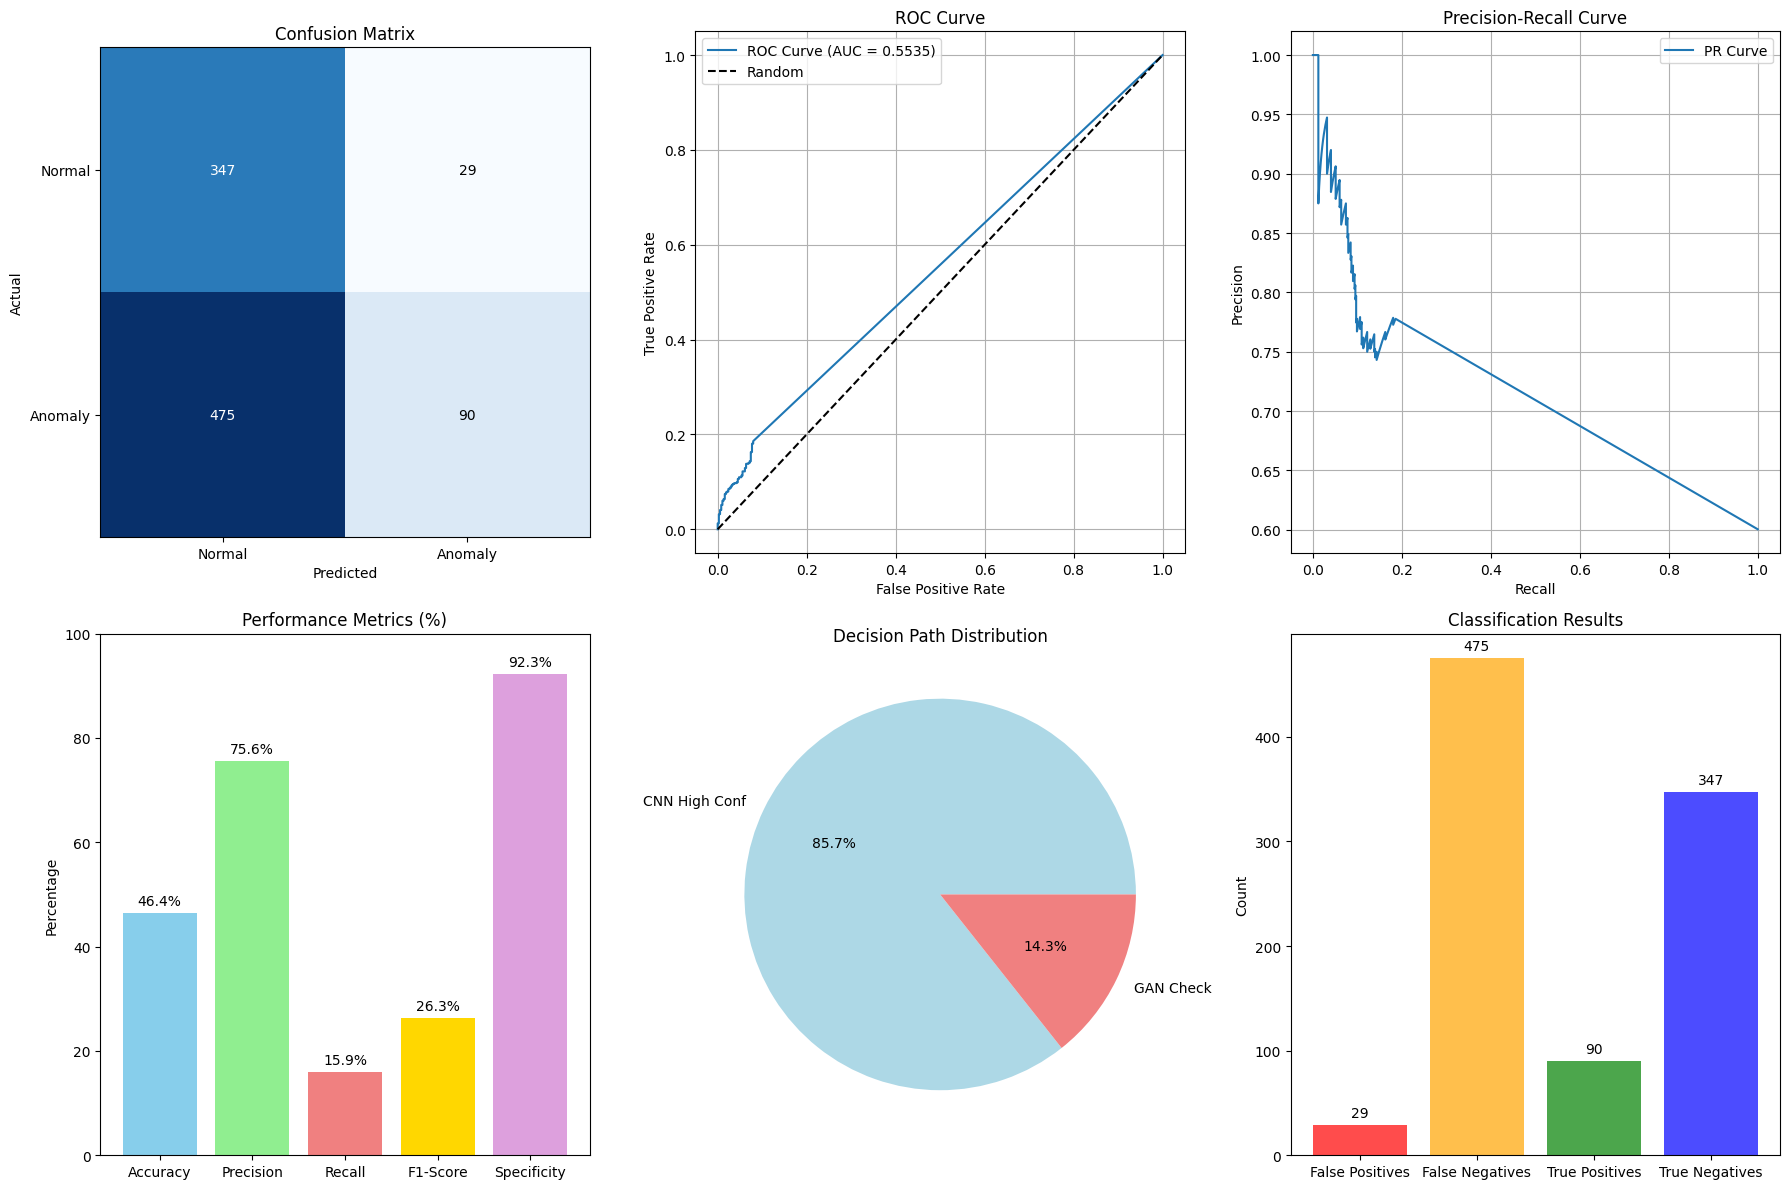


✅ Comprehensive evaluation results saved to gan_anomaly_results2_cnn_0.85.csv

🧪 Testing CNN confidence threshold: 0.9

🔍 EVALUATING HYBRID GAN ANOMALY DETECTOR
CNN confidence threshold: 0.9
GAN anomaly threshold: 0.081837

📊 Processing 376 normal images...
  Progress: 0/376
  Progress: 50/376
  Progress: 100/376
  Progress: 150/376
  Progress: 200/376
  Progress: 250/376
  Progress: 300/376
  Progress: 350/376

📊 Processing 565 anomalous images...
  Progress: 0/565
  Progress: 50/565
  Progress: 100/565
  Progress: 150/565
  Progress: 200/565
  Progress: 250/565
  Progress: 300/565
  Progress: 350/565
  Progress: 400/565
  Progress: 450/565
  Progress: 500/565
  Progress: 550/565

🎯 HYBRID GAN ANOMALY DETECTION EVALUATION RESULTS
📋 Configuration:
   CNN Confidence Threshold: 0.9
   GAN Anomaly Threshold: 0.081837
   Total Images Processed: 941
   Normal Images: 376
   Anomalous Images: 565

🛣️  Decision Path Analysis:
   CNN High Confidence Decisions: 783 (83.2%)
   GAN Anomaly Check

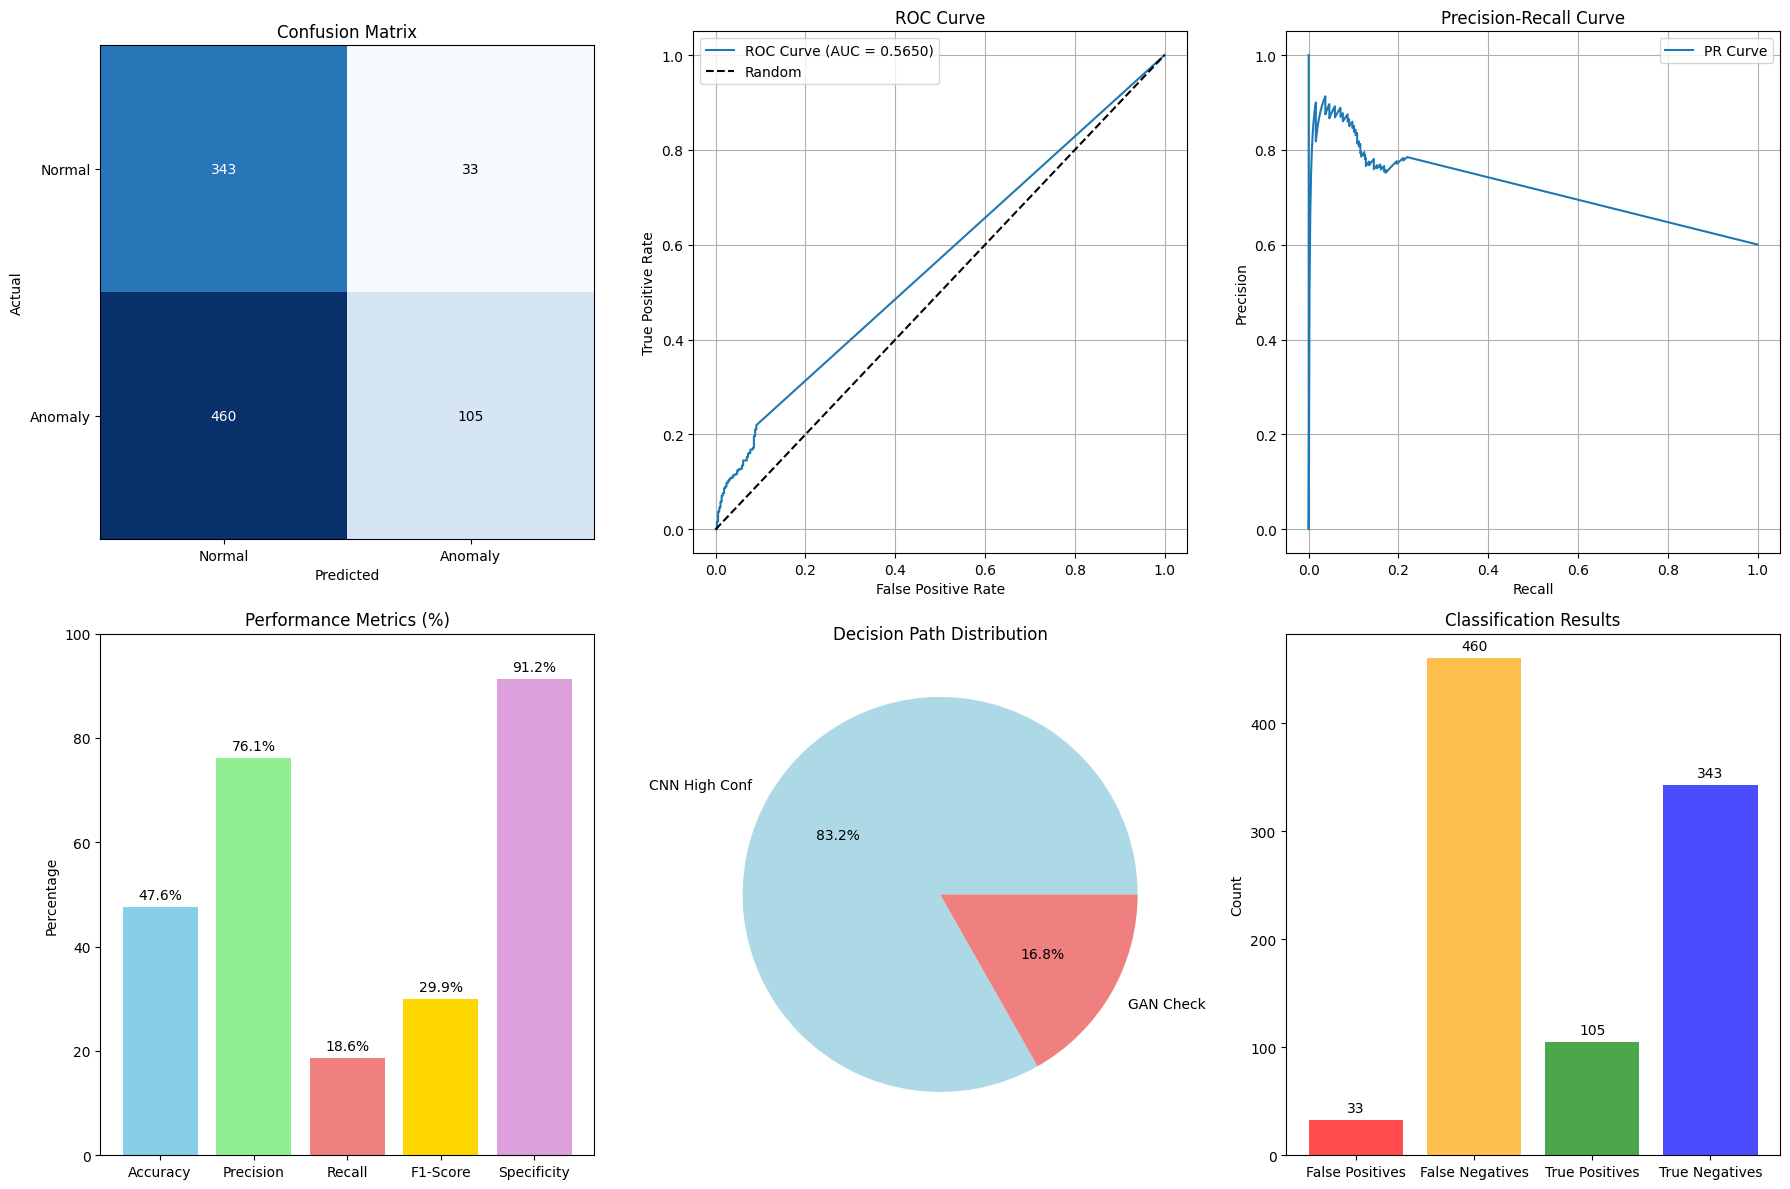


✅ Comprehensive evaluation results saved to gan_anomaly_results2_cnn_0.9.csv

🧪 Testing CNN confidence threshold: 0.95

🔍 EVALUATING HYBRID GAN ANOMALY DETECTOR
CNN confidence threshold: 0.95
GAN anomaly threshold: 0.081837

📊 Processing 376 normal images...
  Progress: 0/376
  Progress: 50/376
  Progress: 100/376
  Progress: 150/376
  Progress: 200/376
  Progress: 250/376
  Progress: 300/376
  Progress: 350/376

📊 Processing 565 anomalous images...
  Progress: 0/565
  Progress: 50/565
  Progress: 100/565
  Progress: 150/565
  Progress: 200/565
  Progress: 250/565
  Progress: 300/565
  Progress: 350/565
  Progress: 400/565
  Progress: 450/565
  Progress: 500/565
  Progress: 550/565

🎯 HYBRID GAN ANOMALY DETECTION EVALUATION RESULTS
📋 Configuration:
   CNN Confidence Threshold: 0.95
   GAN Anomaly Threshold: 0.081837
   Total Images Processed: 941
   Normal Images: 376
   Anomalous Images: 565

🛣️  Decision Path Analysis:
   CNN High Confidence Decisions: 741 (78.7%)
   GAN Anomaly Che

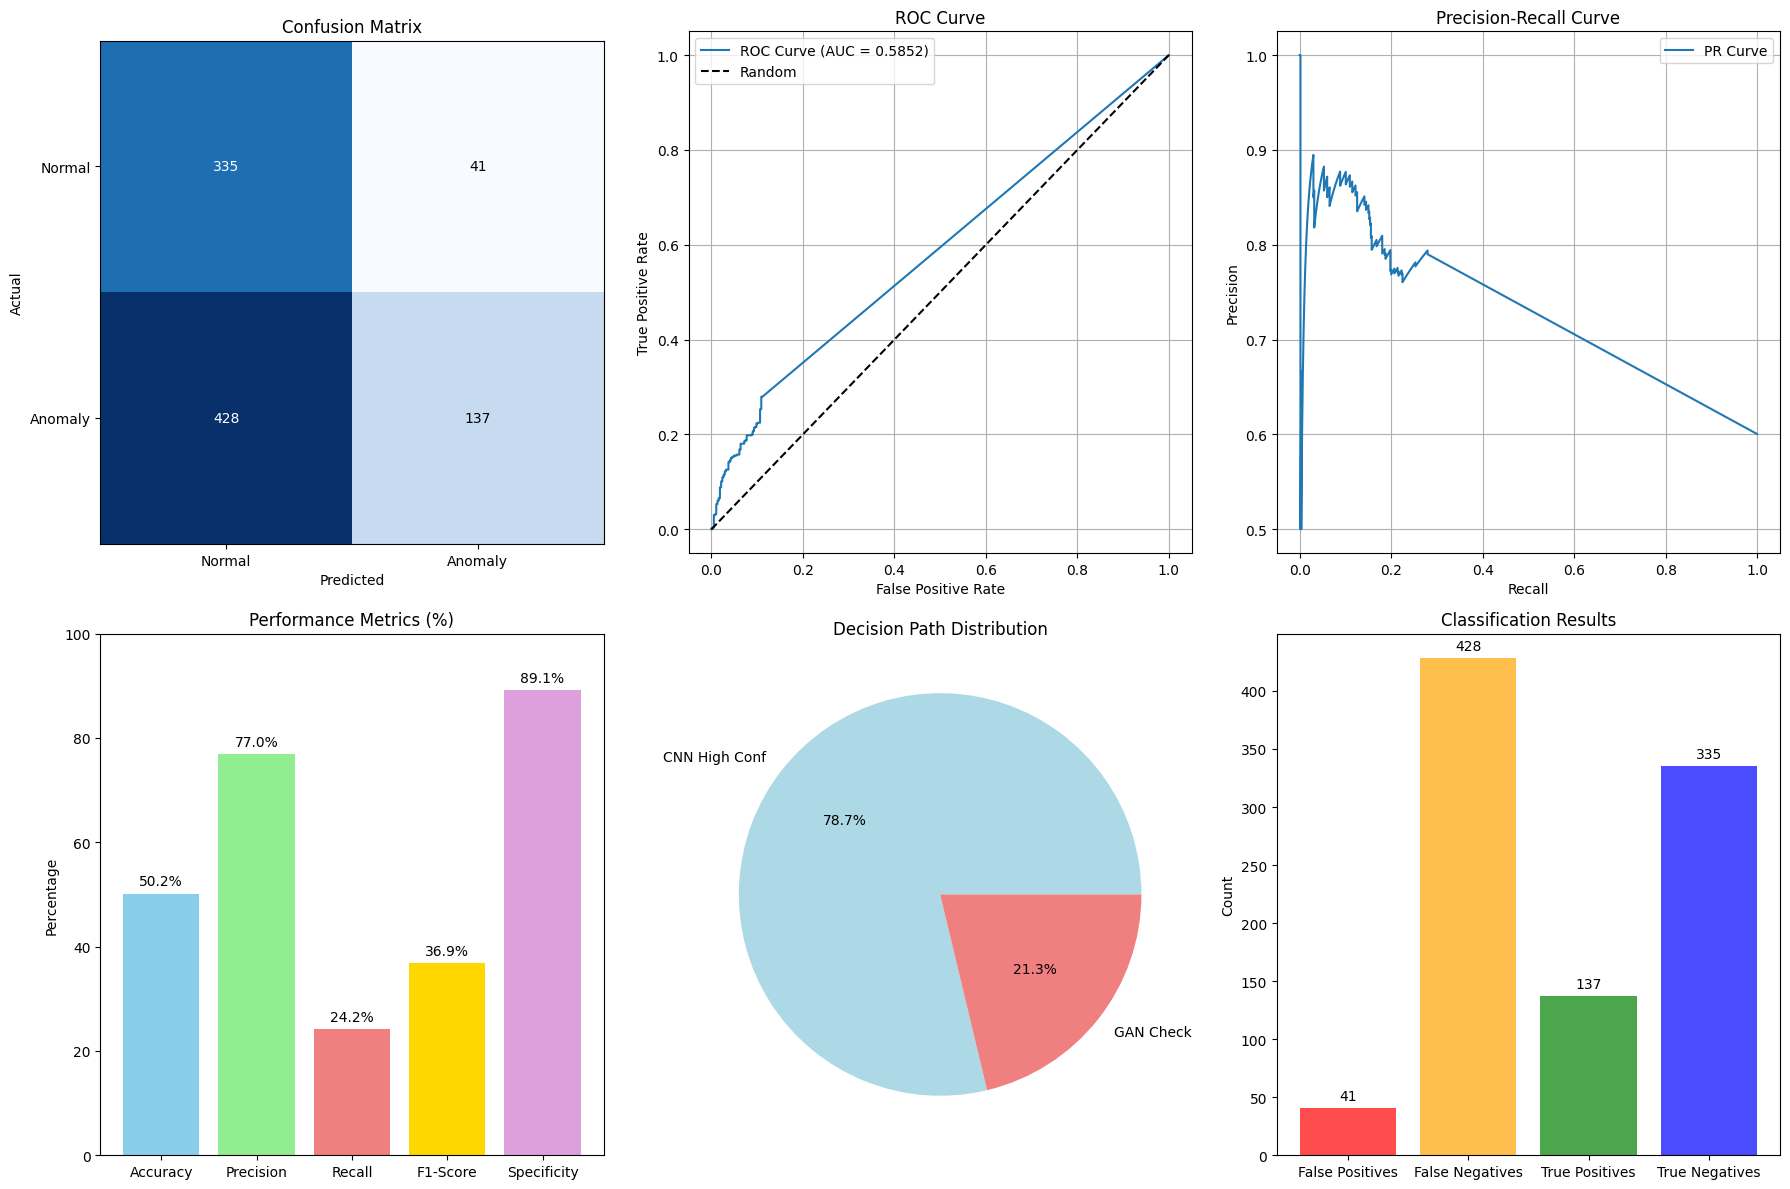


✅ Comprehensive evaluation results saved to gan_anomaly_results2_cnn_0.95.csv

🧪 Testing CNN confidence threshold: 1.0

🔍 EVALUATING HYBRID GAN ANOMALY DETECTOR
CNN confidence threshold: 1.0
GAN anomaly threshold: 0.081837

📊 Processing 376 normal images...
  Progress: 0/376
  Progress: 50/376
  Progress: 100/376
  Progress: 150/376
  Progress: 200/376
  Progress: 250/376
  Progress: 300/376
  Progress: 350/376

📊 Processing 565 anomalous images...
  Progress: 0/565
  Progress: 50/565
  Progress: 100/565
  Progress: 150/565
  Progress: 200/565
  Progress: 250/565
  Progress: 300/565
  Progress: 350/565
  Progress: 400/565
  Progress: 450/565
  Progress: 500/565
  Progress: 550/565

🎯 HYBRID GAN ANOMALY DETECTION EVALUATION RESULTS
📋 Configuration:
   CNN Confidence Threshold: 1.0
   GAN Anomaly Threshold: 0.081837
   Total Images Processed: 941
   Normal Images: 376
   Anomalous Images: 565

🛣️  Decision Path Analysis:
   CNN High Confidence Decisions: 295 (31.3%)
   GAN Anomaly Check

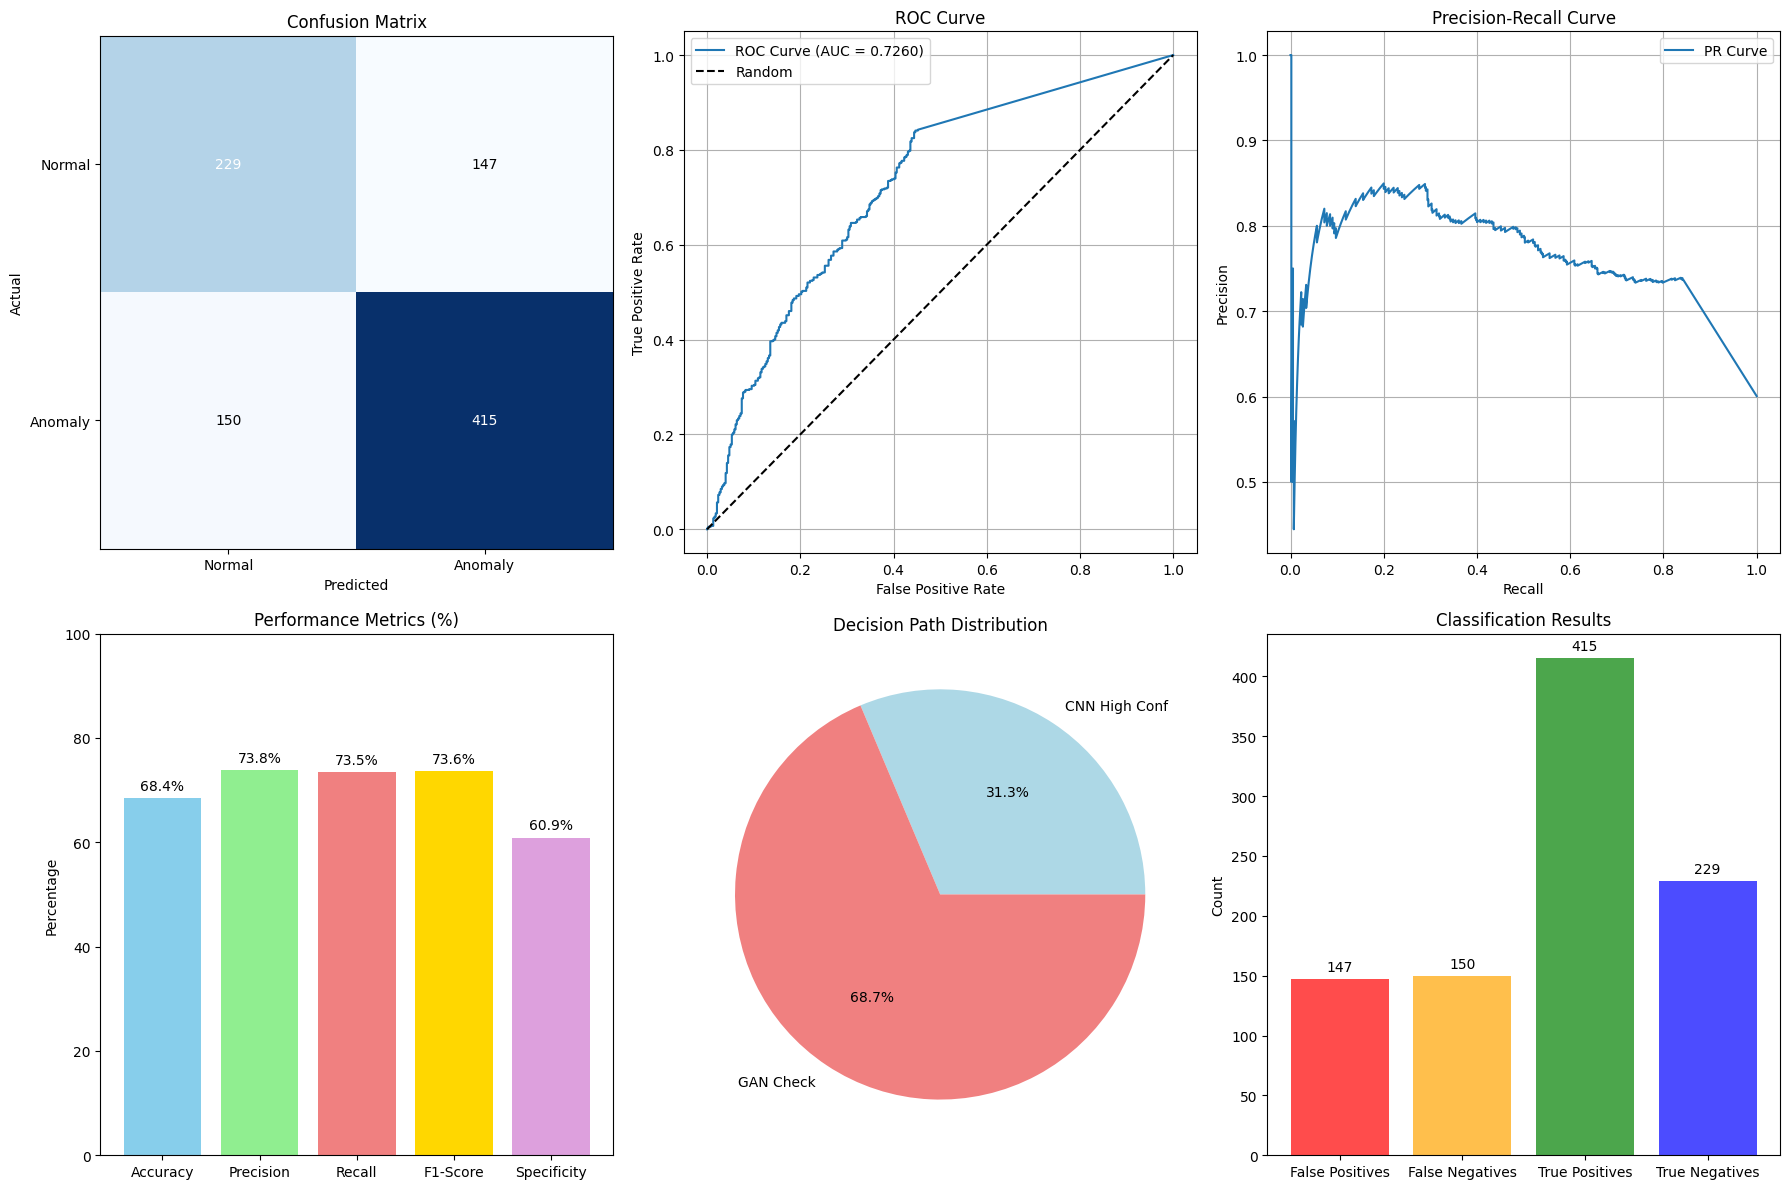


✅ Comprehensive evaluation results saved to gan_anomaly_results2_cnn_1.0.csv

📊 THRESHOLD COMPARISON SUMMARY
CNN Threshold   Accuracy   Precision    Recall     F1-Score   Specificity  ROC AUC   
----------------------------------------------------------------------------------------------------
0.85            46.44    % 75.63      % 15.93    % 26.32    % 92.29      % 0.5535    
0.9             47.61    % 76.09      % 18.58    % 29.87    % 91.22      % 0.5650    
0.95            50.16    % 76.97      % 24.25    % 36.88    % 89.10      % 0.5852    
1.0             68.44    % 73.84      % 73.45    % 73.65    % 60.90      % 0.7260    

✅ Threshold comparison summary saved to gan_threshold_comparison_summary.csv


In [23]:
results_summary = test_multiple_gan_thresholds(
    'testing/normal', 
    'testing/anomaly2'
)

In [ ]:
# =============================================================================
# IMPROVED GAN ANOMALY DETECTION WITH BETTER THRESHOLDING AND SCORING
# =============================================================================

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

def improved_gan_anomaly_scores(gan_model, images, batch_size=4):
    """Improved anomaly scoring with better normalization and multiple metrics"""
    
    anomaly_scores = []
    reconstruction_errors = []
    discriminator_scores = []
    feature_distances = []
    
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        batch_normalized = (batch * 2.0) - 1.0
        
        # 1. Enhanced Discriminator Analysis
        disc_logits = gan_model.discriminator(batch_normalized, training=False)
        # Use raw logits instead of sigmoid for better separation
        disc_raw_scores = disc_logits.numpy().flatten()
        
        # 2. Feature-based Analysis with Multiple Attempts
        real_features = gan_model.feature_extractor(batch_normalized, training=False)
        
        batch_best_errors = []
        batch_feature_dists = []
        
        for img_idx in range(batch.shape[0]):
            single_img = batch_normalized[img_idx:img_idx+1]
            single_real_features = real_features[img_idx:img_idx+1]
            
            best_reconstruction_error = float('inf')
            best_feature_distance = float('inf')
            
            # Multiple reconstruction attempts with different strategies
            for attempt in range(15):  # Increased attempts
                if attempt < 5:
                    # Standard normal distribution
                    noise = tf.random.normal([1, gan_model.latent_dim], mean=0.0, stddev=1.0)
                elif attempt < 10:
                    # Slightly different variance
                    noise = tf.random.normal([1, gan_model.latent_dim], mean=0.0, stddev=0.8)
                else:
                    # Uniform distribution converted to normal-like
                    uniform_noise = tf.random.uniform([1, gan_model.latent_dim], -1.0, 1.0)
                    noise = tf.nn.tanh(uniform_noise) * 1.2
                
                try:
                    generated_img = gan_model.generator(noise, training=False)
                    generated_features = gan_model.feature_extractor(generated_img, training=False)
                    
                    # Feature distance (Cosine + Euclidean)
                    cosine_dist = tf.keras.utils.cosine_similarity(single_real_features, generated_features)
                    cosine_dist = 1.0 - tf.reduce_mean(cosine_dist).numpy()
                    
                    euclidean_dist = tf.reduce_mean(tf.square(single_real_features - generated_features)).numpy()
                    
                    feature_distance = 0.6 * euclidean_dist + 0.4 * cosine_dist
                    
                    # Image reconstruction error (multiple metrics)
                    mse_error = tf.reduce_mean(tf.square(single_img - generated_img)).numpy()
                    mae_error = tf.reduce_mean(tf.abs(single_img - generated_img)).numpy()
                    
                    # Structural similarity consideration
                    img_flat = tf.reshape(single_img, [-1])
                    gen_flat = tf.reshape(generated_img, [-1])
                    correlation = tf.reduce_mean((img_flat - tf.reduce_mean(img_flat)) * 
                                               (gen_flat - tf.reduce_mean(gen_flat))).numpy()
                    correlation = max(0, correlation)  # Only positive correlations
                    structural_error = 1.0 - correlation
                    
                    # Combined reconstruction error
                    reconstruction_error = (0.4 * mse_error + 0.3 * mae_error + 
                                          0.2 * feature_distance + 0.1 * structural_error)
                    
                    if reconstruction_error < best_reconstruction_error:
                        best_reconstruction_error = reconstruction_error
                        best_feature_distance = feature_distance
                        
                except Exception as e:
                    continue
            
            batch_best_errors.append(best_reconstruction_error)
            batch_feature_dists.append(best_feature_distance)
        
        # Store results
        for j in range(len(disc_raw_scores)):
            reconstruction_errors.append(batch_best_errors[j])
            feature_distances.append(batch_feature_dists[j])
            discriminator_scores.append(disc_raw_scores[j])
    
    # Convert to numpy arrays
    reconstruction_errors = np.array(reconstruction_errors)
    feature_distances = np.array(feature_distances)
    discriminator_scores = np.array(discriminator_scores)
    
    # Normalize scores to [0, 1] range for better combination
    def robust_normalize(scores):
        """Robust normalization using percentiles"""
        p5, p95 = np.percentile(scores, [5, 95])
        normalized = (scores - p5) / (p95 - p5)
        return np.clip(normalized, 0, 1)
    
    # Normalize each component
    norm_recon = robust_normalize(reconstruction_errors)
    norm_features = robust_normalize(feature_distances)
    
    # Transform discriminator scores (lower is more anomalous)
    # Use sigmoid transformation for better distribution
    disc_transformed = 1.0 / (1.0 + np.exp(discriminator_scores))
    
    # Weighted combination with better balancing
    combined_anomaly_scores = (0.45 * norm_recon + 
                              0.35 * norm_features + 
                              0.20 * disc_transformed)
    
    return (combined_anomaly_scores, reconstruction_errors, 
            discriminator_scores, feature_distances)

def calculate_improved_thresholds(train_scores, method='multi_method'):
    """Calculate improved thresholds using multiple statistical methods"""
    
    thresholds = {}
    
    # Method 1: Robust statistics (less sensitive to outliers)
    q75 = np.percentile(train_scores, 75)
    q95 = np.percentile(train_scores, 95)
    iqr = np.percentile(train_scores, 75) - np.percentile(train_scores, 25)
    
    # Adaptive threshold based on distribution shape
    skewness = stats.skew(train_scores)
    kurtosis = stats.kurtosis(train_scores)
    
    # Adjust threshold based on distribution characteristics
    if skewness > 1.0:  # Right-skewed distribution
        base_percentile = 85
    elif skewness < -1.0:  # Left-skewed distribution
        base_percentile = 90
    else:  # Approximately normal
        base_percentile = 88
    
    # Adjust for kurtosis (tail thickness)
    if kurtosis > 3:  # Heavy tails
        base_percentile += 2
    elif kurtosis < 0:  # Light tails
        base_percentile -= 2
    
    thresholds['robust_percentile'] = np.percentile(train_scores, base_percentile)
    
    # Method 2: Gaussian Mixture Model (find natural separation)
    try:
        gmm = GaussianMixture(n_components=2, random_state=42)
        gmm.fit(train_scores.reshape(-1, 1))
        
        # Find the intersection point of the two gaussians
        means = gmm.means_.flatten()
        weights = gmm.weights_
        
        if len(means) == 2:
            # Threshold at the point where the minority component becomes dominant
            threshold_gmm = np.mean(means) + 0.5 * np.std(train_scores)
            thresholds['gmm_based'] = min(threshold_gmm, np.percentile(train_scores, 95))
        else:
            thresholds['gmm_based'] = thresholds['robust_percentile']
    except:
        thresholds['gmm_based'] = thresholds['robust_percentile']
    
    # Method 3: Modified Z-score with robust estimates
    median_score = np.median(train_scores)
    mad = np.median(np.abs(train_scores - median_score))  # Median Absolute Deviation
    
    if mad > 0:
        # Find threshold where modified z-score = 2.5 (less strict than 3.5)
        threshold_zscore = median_score + 2.5 * mad / 0.6745
        thresholds['modified_zscore'] = min(threshold_zscore, np.percentile(train_scores, 95))
    else:
        thresholds['modified_zscore'] = thresholds['robust_percentile']
    
    # Method 4: Elbow method (find the "elbow" in the score distribution)
    sorted_scores = np.sort(train_scores)[::-1]  # Descending order
    n_points = len(sorted_scores)
    
    # Calculate the "elbow" using the distance from line connecting first and last points
    if n_points > 10:
        # Use only top portion for elbow detection
        top_portion = int(n_points * 0.15)  # Top 15%
        scores_subset = sorted_scores[:top_portion]
        
        # Find elbow point
        n_subset = len(scores_subset)
        if n_subset > 2:
            distances = []
            for i in range(1, n_subset - 1):
                # Distance from point to line connecting first and last
                x1, y1 = 0, scores_subset[0]
                x2, y2 = n_subset - 1, scores_subset[-1]
                x0, y0 = i, scores_subset[i]
                
                distance = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1) / \
                          np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
                distances.append(distance)
            
            if distances:
                elbow_idx = np.argmax(distances) + 1
                thresholds['elbow_method'] = scores_subset[elbow_idx]
            else:
                thresholds['elbow_method'] = thresholds['robust_percentile']
        else:
            thresholds['elbow_method'] = thresholds['robust_percentile']
    else:
        thresholds['elbow_method'] = thresholds['robust_percentile']
    
    # Combine methods for final threshold
    threshold_values = list(thresholds.values())
    
    # Use median of methods, but ensure it's reasonable
    final_threshold = np.median(threshold_values)
    
    # Ensure threshold is within reasonable bounds
    min_reasonable = np.percentile(train_scores, 80)
    max_reasonable = np.percentile(train_scores, 98)
    
    final_threshold = np.clip(final_threshold, min_reasonable, max_reasonable)
    thresholds['final_combined'] = final_threshold
    
    return thresholds

def improved_hybrid_prediction(image_path, cnn_model, gan_model, threshold_dict, 
                              cnn_confidence_threshold=0.85, target_size=(128, 128)):
    """Improved hybrid prediction with better decision logic"""
    
    # Load and preprocess image
    test_image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    test_image_array = tf.keras.preprocessing.image.img_to_array(test_image)
    test_image_array = np.expand_dims(test_image_array, axis=0)
    test_image_normalized = test_image_array / 255.0
    
    # CNN Prediction
    cnn_prediction = cnn_model.predict(test_image_normalized, verbose=0)
    predicted_class_index = np.argmax(cnn_prediction)
    cnn_confidence = np.max(cnn_prediction)
    
    # Get class names
    class_names = list(training_set.class_indices.keys())
    predicted_class = class_names[predicted_class_index]
    
    # Improved decision logic
    if cnn_confidence >= cnn_confidence_threshold:
        # High confidence CNN prediction
        is_anomaly = False
        anomaly_score = 0.0
        reconstruction_error = 0.0
        discriminator_score = 1.0
        feature_distance = 0.0
        decision_path = "CNN_HIGH_CONFIDENCE"
        final_prediction = predicted_class
    else:
        # Low confidence - use improved GAN analysis
        gan_scores, recon_errors, disc_scores, feature_dists = improved_gan_anomaly_scores(
            gan_model, test_image_normalized, batch_size=1
        )
        
        anomaly_score = gan_scores[0]
        reconstruction_error = recon_errors[0]
        discriminator_score = disc_scores[0]
        feature_distance = feature_dists[0]
        
        # Multi-criteria decision
        main_threshold = threshold_dict['final_combined']
        
        # Primary criterion: main anomaly score
        criterion_1 = anomaly_score > main_threshold
        
        # Secondary criterion: very low CNN confidence
        criterion_2 = cnn_confidence < 0.6
        
        # Tertiary criterion: discriminator confidence
        criterion_3 = discriminator_score < -1.0  # Very negative logit
        
        # Decision logic: need main criterion OR (low CNN confidence AND discriminator agrees)
        is_anomaly = criterion_1 or (criterion_2 and criterion_3)
        
        decision_path = "GAN_ANOMALY_CHECK"
        
        if is_anomaly:
            final_prediction = "ANOMALY"
        else:
            final_prediction = predicted_class
    
    return {
        'predicted_class': predicted_class,
        'final_prediction': final_prediction,
        'cnn_confidence': cnn_confidence,
        'gan_anomaly_score': anomaly_score,
        'reconstruction_error': reconstruction_error,
        'discriminator_score': discriminator_score,
        'feature_distance': feature_distance,
        'is_anomaly': is_anomaly,
        'decision_path': decision_path,
        'threshold_used': threshold_dict.get('final_combined', 0.0)
    }

def setup_improved_training_thresholds(training_set, gan_model, num_samples=8000):
    """Setup improved training thresholds with better statistics"""
    
    print("🔧 Setting up improved GAN anomaly detection thresholds...")
    print("="*60)
    
    # Collect training samples
    print(f"Collecting {num_samples} training samples...")
    train_images = []
    samples_collected = 0
    
    while samples_collected < num_samples:
        try:
            batch_x, batch_y = next(training_set)
            for img in batch_x:
                if samples_collected >= num_samples:
                    break
                train_images.append(img)
                samples_collected += 1
                
                if samples_collected % 1000 == 0:
                    print(f"  Collected {samples_collected}/{num_samples} samples...")
                    
        except StopIteration:
            training_set.reset()
            continue
    
    train_images = np.array(train_images)
    
    print("Calculating improved GAN anomaly scores...")
    train_anomaly_scores, train_recon_errors, train_disc_scores, train_feature_dists = \
        improved_gan_anomaly_scores(gan_model, train_images, batch_size=8)
    
    print("Computing multiple threshold methods...")
    thresholds = calculate_improved_thresholds(train_anomaly_scores)
    
    # Display threshold analysis
    print(f"\n📊 Improved Threshold Analysis:")
    print(f"   Training score statistics:")
    print(f"   - Mean: {np.mean(train_anomaly_scores):.6f}")
    print(f"   - Std:  {np.std(train_anomaly_scores):.6f}")
    print(f"   - Median: {np.median(train_anomaly_scores):.6f}")
    print(f"   - Skewness: {stats.skew(train_anomaly_scores):.3f}")
    print(f"   - Kurtosis: {stats.kurtosis(train_anomaly_scores):.3f}")
    
    print(f"\n   Threshold methods:")
    for method, threshold in thresholds.items():
        percentile_rank = (np.sum(train_anomaly_scores <= threshold) / len(train_anomaly_scores)) * 100
        print(f"   - {method}: {threshold:.6f} ({percentile_rank:.1f}th percentile)")
    
    # Visualization of improved distributions
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 1. Improved anomaly scores with multiple thresholds
    axes[0, 0].hist(train_anomaly_scores, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
    
    # Plot different thresholds
    colors = ['red', 'orange', 'green', 'purple', 'brown']
    for i, (method, threshold) in enumerate(thresholds.items()):
        if i < len(colors):
            axes[0, 0].axvline(threshold, color=colors[i], linestyle='--', 
                              label=f'{method}: {threshold:.4f}')
    
    axes[0, 0].set_xlabel('Improved GAN Anomaly Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Improved Anomaly Scores')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Reconstruction errors
    axes[0, 1].hist(train_recon_errors, bins=50, alpha=0.7, edgecolor='black', color='orange')
    axes[0, 1].set_xlabel('Reconstruction Error')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Reconstruction Errors')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Discriminator scores (raw logits)
    axes[0, 2].hist(train_disc_scores, bins=50, alpha=0.7, edgecolor='black', color='green')
    axes[0, 2].set_xlabel('Discriminator Score (Raw Logits)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Distribution of Discriminator Scores')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Feature distances
    axes[1, 0].hist(train_feature_dists, bins=50, alpha=0.7, edgecolor='black', color='purple')
    axes[1, 0].set_xlabel('Feature Distance')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Feature Distances')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Q-Q plot for normality check
    stats.probplot(train_anomaly_scores, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot: Anomaly Scores vs Normal Distribution')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Cumulative distribution
    sorted_scores = np.sort(train_anomaly_scores)
    cumulative = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)
    axes[1, 2].plot(sorted_scores, cumulative, 'b-', linewidth=2)
    
    # Mark thresholds on cumulative plot
    final_threshold = thresholds['final_combined']
    threshold_percentile = np.interp(final_threshold, sorted_scores, cumulative)
    axes[1, 2].axvline(final_threshold, color='red', linestyle='--', 
                      label=f'Final Threshold: {final_threshold:.4f}\n({threshold_percentile*100:.1f}th percentile)')
    
    axes[1, 2].set_xlabel('Anomaly Score')
    axes[1, 2].set_ylabel('Cumulative Probability')
    axes[1, 2].set_title('Cumulative Distribution of Anomaly Scores')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Improved threshold setup completed!")
    print(f"   Final combined threshold: {thresholds['final_combined']:.6f}")
    print(f"   This corresponds to the {threshold_percentile*100:.1f}th percentile of training data")
    
    return thresholds, train_anomaly_scores

# =============================================================================
# USAGE EXAMPLE
# =============================================================================

def run_improved_evaluation(normal_folder, anomaly_folder, cnn_model, gan_model):
    """Run the complete improved evaluation"""
    
    print("🚀 Starting Improved GAN Anomaly Detection Evaluation")
    print("="*70)
    
    # Step 1: Setup improved thresholds
    thresholds, training_scores = setup_improved_training_thresholds(training_set, gan_model)
    
    # Step 2: Set improved CNN confidence threshold
    improved_cnn_threshold = 0.85  # Slightly lower to let more cases through to GAN
    
    print(f"\n🎯 Evaluation Configuration:")
    print(f"   CNN Confidence Threshold: {improved_cnn_threshold}")
    print(f"   GAN Anomaly Threshold: {thresholds['final_combined']:.6f}")
    
    # Step 3: Evaluate on test data
    results = evaluate_improved_system(normal_folder, anomaly_folder, cnn_model, 
                                     gan_model, thresholds, improved_cnn_threshold)
    
    return results

def evaluate_improved_system(normal_folder, anomaly_folder, cnn_model, gan_model, 
                           thresholds, cnn_confidence_threshold):
    """Evaluate the improved system"""
    
    normal_paths = get_image_paths_from_folders([normal_folder])
    anomaly_paths = get_image_paths_from_folders([anomaly_folder])
    
    y_true, y_pred, y_scores = [], [], []
    tp, fp, tn, fn = 0, 0, 0, 0
    cnn_high_conf, gan_decisions = 0, 0
    
    print(f"\n📊 Processing {len(normal_paths)} normal images...")
    for i, img_path in enumerate(normal_paths):
        if i % 50 == 0:
            print(f"  Progress: {i}/{len(normal_paths)}")
        
        try:
            result = improved_hybrid_prediction(img_path, cnn_model, gan_model, thresholds, 
                                              cnn_confidence_threshold)
            
            if result['decision_path'] == "CNN_HIGH_CONFIDENCE":
                cnn_high_conf += 1
            else:
                gan_decisions += 1
            
            y_true.append(0)
            y_pred.append(1 if result['is_anomaly'] else 0)
            y_scores.append(result['gan_anomaly_score'])
            
            if result['is_anomaly']:
                fp += 1
            else:
                tn += 1
                
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    print(f"\n📊 Processing {len(anomaly_paths)} anomalous images...")
    for i, img_path in enumerate(anomaly_paths):
        if i % 50 == 0:
            print(f"  Progress: {i}/{len(anomaly_paths)}")
        
        try:
            result = improved_hybrid_prediction(img_path, cnn_model, gan_model, thresholds, 
                                              cnn_confidence_threshold)
            
            if result['decision_path'] == "CNN_HIGH_CONFIDENCE":
                cnn_high_conf += 1
            else:
                gan_decisions += 1
            
            y_true.append(1)
            y_pred.append(1 if result['is_anomaly'] else 0)
            y_scores.append(result['gan_anomaly_score'])
            
            if result['is_anomaly']:
                tp += 1
            else:
                fn += 1
                
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    # Calculate metrics
    total = len(y_true)
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    fpr = fp / (tn + fp) if (tn + fp) > 0 else 0
    fnr = fn / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\n🎯 IMPROVED RESULTS:")
    print(f"   Total Images: {total}")
    print(f"   CNN High Confidence: {cnn_high_conf} ({cnn_high_conf/total*100:.1f}%)")
    print(f"   GAN Decisions: {gan_decisions} ({gan_decisions/total*100:.1f}%)")
    print(f"\n   Confusion Matrix:")
    print(f"   TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print(f"\n   Performance Metrics:")
    print(f"   Accuracy: {accuracy*100:.2f}%")
    print(f"   Precision: {precision*100:.2f}%")
    print(f"   Recall: {recall*100:.2f}%")
    print(f"   F1-Score: {f1*100:.2f}%")
    print(f"   Specificity: {specificity*100:.2f}%")
    print(f"   False Positive Rate: {fpr*100:.2f}%")
    print(f"   False Negative Rate: {fnr*100:.2f}%")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'fpr': fpr,
        'fnr': fnr
    }

# =============================================================================
# TO USE THE IMPROVED SYSTEM:
# =============================================================================

improved_thresholds, training_scores = setup_improved_training_thresholds(training_set, gan_model)
normal_folder = 'testing/normal'
anomaly_folder = 'testing/anomaly2'
results = run_improved_evaluation(normal_folder, anomaly_folder, model, gan_model)

"""
# Replace your existing threshold calculation with:
improved_thresholds, training_scores = setup_improved_training_thresholds(training_set, gan_model)

# Then run evaluation with:
results = run_improved_evaluation(normal_folder, anomaly_folder, model, gan_model)
"""

🔧 Setting up improved GAN anomaly detection thresholds...
  Collected 1000/8000 samples...
  Collected 2000/8000 samples...
  Collected 3000/8000 samples...
  Collected 4000/8000 samples...
  Collected 5000/8000 samples...
  Collected 6000/8000 samples...
  Collected 7000/8000 samples...
  Collected 8000/8000 samples...
Calculating improved GAN anomaly scores...
